# Multivariate ITS model for saturated markets

This notebook focusses on the use of the Multivariate Interrupted Time Series (MVITS) model to estimate where new product sales come from. If you have not yet done so, we recommend that you read our [Introduction to product incrementality](../../guide/customer_choice/incrementality_intro.md) guide as well as the [Multivariate interrupted time series model](../../guide/customer_choice/mv_its_intro.md) guide before continuing.

We will walk through a number of scenarios, from simple to complex, to show how the MVITS model can be used to estimate the impact of a new product on existing products.

## Notebook setup

In [1]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pymc_marketing.customer_choice import MVITS, generate_saturated_data, plot_product

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("default")
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams.update({"figure.constrained_layout.use": True})

seed = sum(map(ord, "Saturated market"))
rng = np.random.default_rng(seed)

## Synthetic data generation

We will generate synthetic data according to the following causal model. This is intentionally simple in this introduction to the MVITS model and is likely not going to capture the complexities of real-world data.

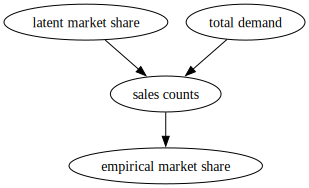

In [4]:
g = gr.Digraph()
g.node(name="share", label="latent market share")
g.node(name="total_demand", label="total demand")
g.node(name="sales_counts", label="sales counts")
g.node(name="empirical_share", label="empirical market share")

g.edge(tail_name="share", head_name="sales_counts")
g.edge(tail_name="total_demand", head_name="sales_counts")
g.edge(tail_name="sales_counts", head_name="empirical_share")
# Render
g

* We assume that there is a latent (unobserved) market share which equates to the popularity of different broducts or brands.
* We assume that there is a level of demand which is broadly stable, but is noisy. Some times more product is sold than other times.
* The empirically observed sales counts are causally influenced by both the latent market share and the total demand. This relationship could be modelled in different ways, but here we assume $\text{sales counts} \sim \mathrm{Multinomial}(\text{total demand}, \text{latent market share})$.

```{admonition} Empirical market share
:class: note

Based off of the observed sales counts, we could calculate empirical market shares. This does not play an important role in our data generation process, but it is important to highlight the difference between noisy empirical observed market shares versus the latent market shares which represent some form of underlying popularity of products or brands.

If we wanted to calculate empirical market share, this would simply be a case of dividing the observed sales (for each product/brand) by the total observed sales.

## Scenario 1 - own versus competitor sales

The first scenario we will examine is the simplest. 

* Our company has launched a new product
* We have sales data covering before and after this product launch
* Regardless of whether we have product level sales data or not, we focus purely on whether the sales of the new product are incremental (taking sales from competitors) or cannibalistic (taking sales from your existing products). As such we operate on data aggregated into "your company total sales" and "all competitor total sales".
* To keep the example simple we have stable market shares which only shift at the point of introducing the new product.
* Complexities such as seasonality in total demand, product pricing or other attributes are ignored and do not feature in this model.

We can generate synthetic data from the causal model described above using the `generate_saturated_data` utility function.

In [5]:
scenario1 = {
    "total_sales_mu": 1000,
    "total_sales_sigma": 5,
    "treatment_time": 40,
    "n_observations": 100,
    "market_shares_before": [[0.7, 0.3, 0]],
    "market_shares_after": [[0.65, 0.25, 0.1]],
    "market_share_labels": ["competitor", "own", "new"],
    "rng": rng,
}

data = generate_saturated_data(**scenario1)
data.head()

product  competitor  own  new   pre
day                                
0               704  304    0  True
1               696  303    0  True
2               698  308    0  True
3               682  317    0  True
4               694  300    0  True

As always, we must visualise the data! We can see noisy but broadly flat sales of your own and all competitor products. Then you launch a new product which sells quite well. Visually we get a sense that the sales of your own and competitor sales drop, but can we put numbers on how incremental or cannabalistic the new product is? That will be the goal of our analysis.

Note: In this example we assume we have a saturated market, so sales of the new product necessarily take sales away from other products.

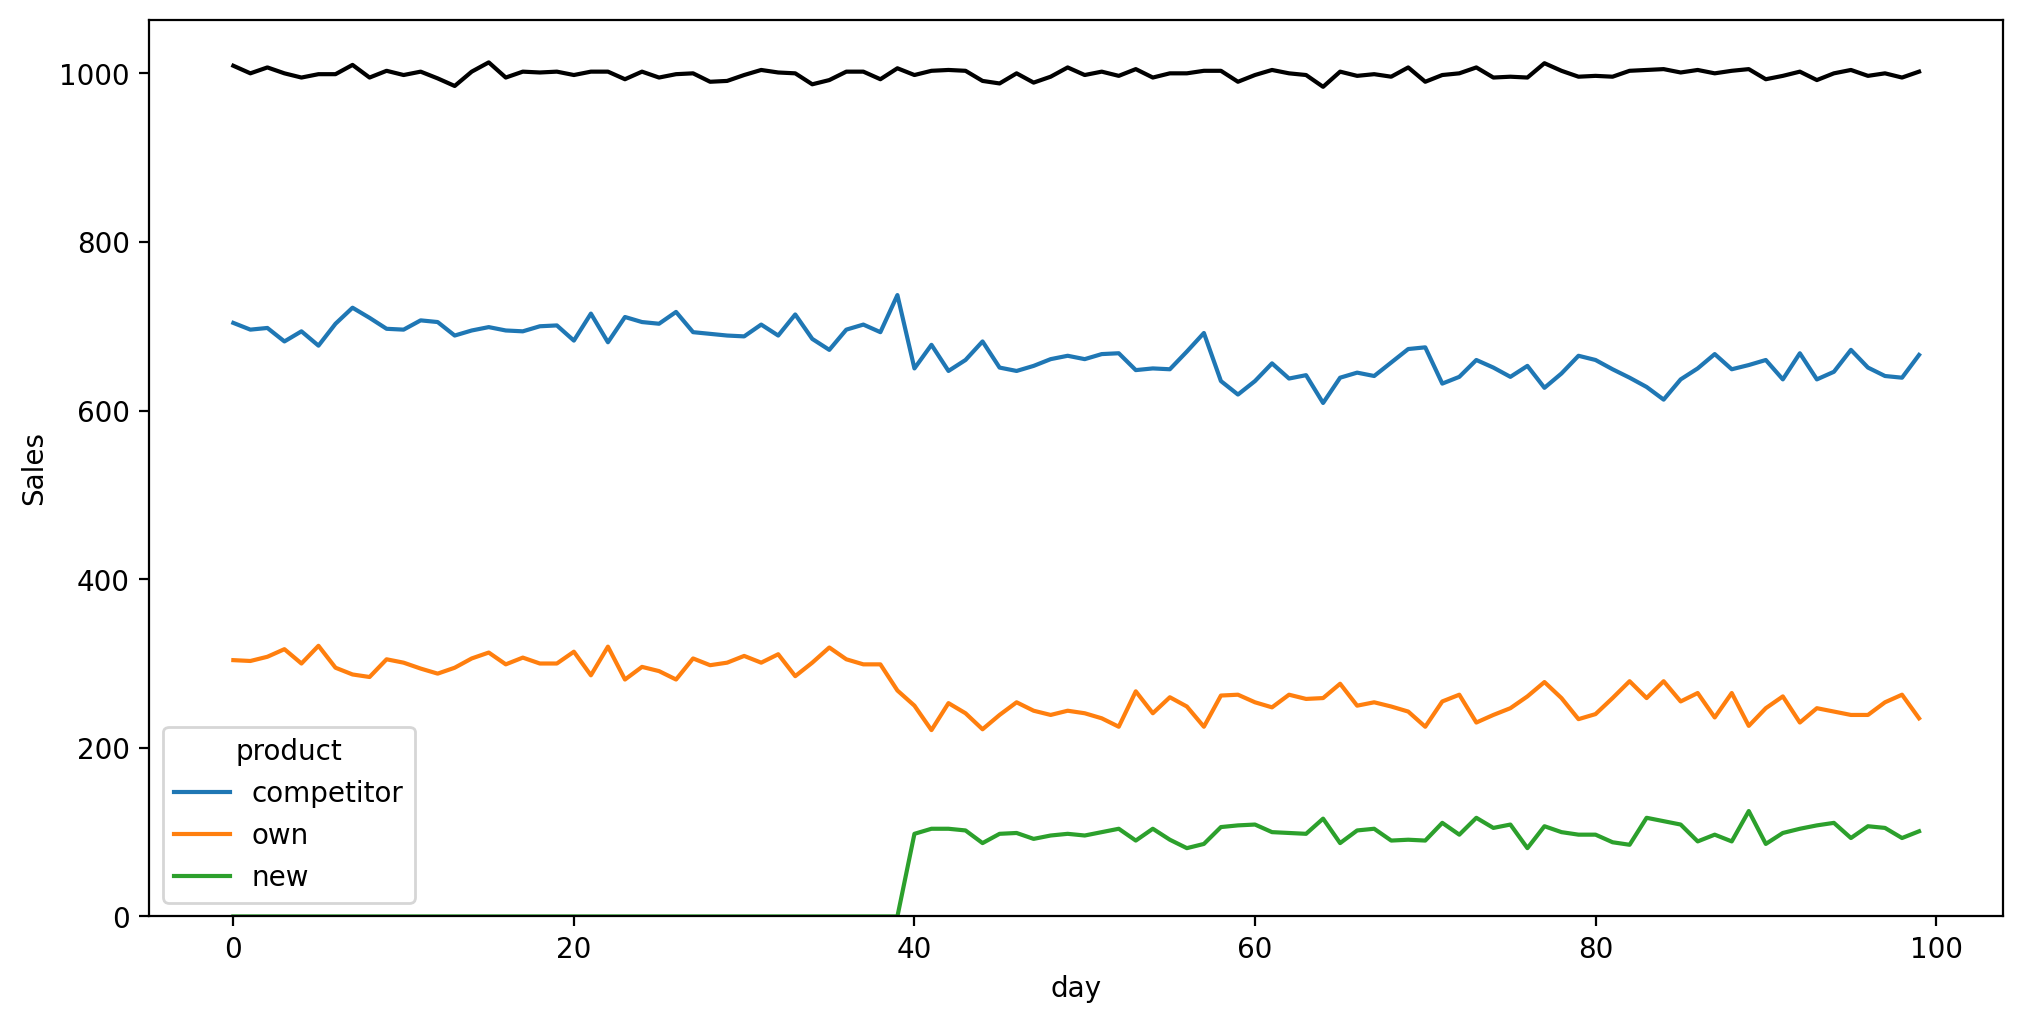

In [6]:
ax = plot_product(data)

Let's take a look at the relationship between the new product sales and both the own and competitor sales. We can see negative correlations, and this makes sense from the MVITS modeling perspective. This is because it models sales of existing products as being _decreased_ by some fraction of the new product sales. So the model assumes that (in the post product launch period) that as the new product sales increase, the sales of the own or competitor will either decrease or remain unchanged. 

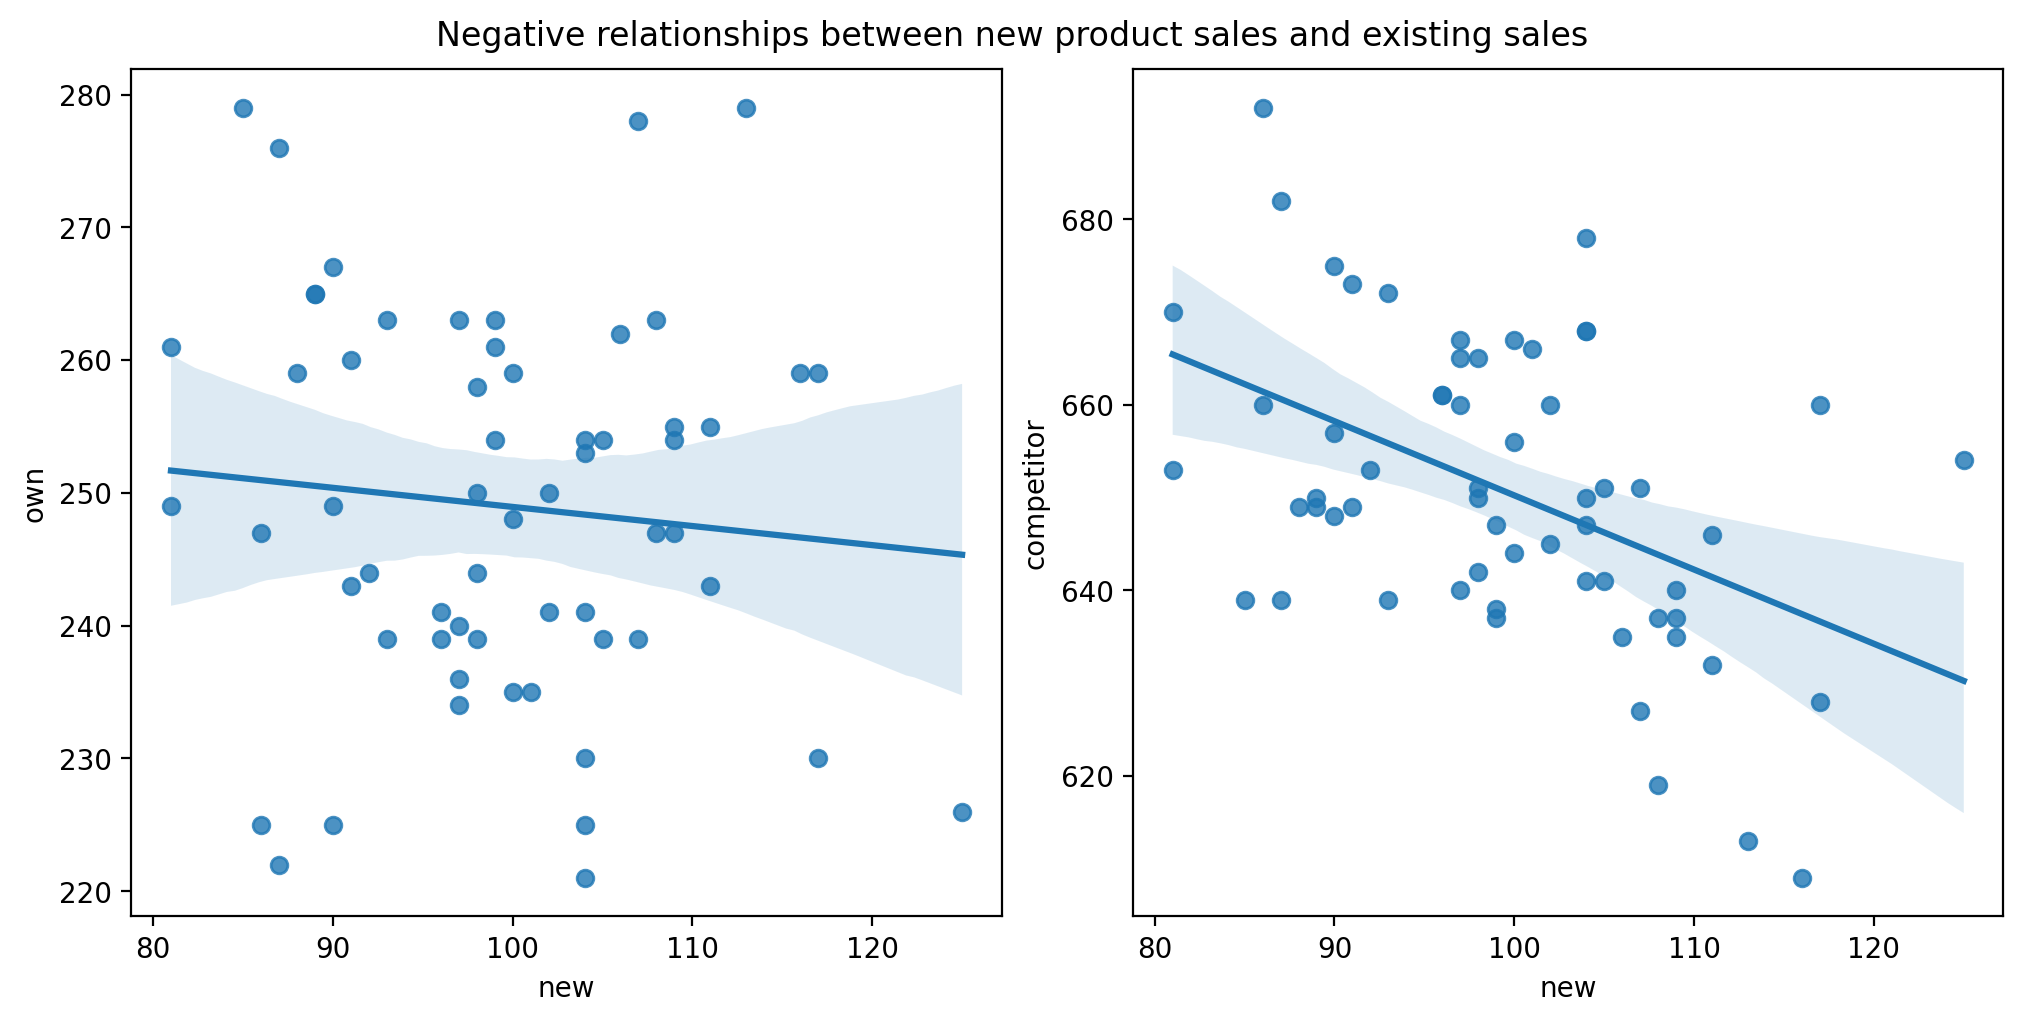

In [7]:
fig, ax = plt.subplots(1, 2)
sns.regplot(data=data.query("pre == False"), x="new", y="own", ax=ax[0])
sns.regplot(data=data.query("pre == False"), x="new", y="competitor", ax=ax[1])
plt.suptitle("Negative relationships between new product sales and existing sales");

### Model building and fitting

We will use the `MVITS` class to analyse the data. We provide the column names corresponding to sales of existing products before the new product introduction. We also set the `saturated_market` flag to `True`. Note, the actual data is provided to the model at a later stage.

In [8]:
model1 = MVITS(
    existing_sales=["competitor", "own"],
    saturated_market=True,
)

In [9]:
model1.model_config

{'intercept': Prior("Normal", dims="existing_product"),
 'likelihood': Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", dims="existing_product"), dims=("time", "existing_product")),
 'market_distribution': Prior("Dirichlet", a=[0.5 0.5], dims="existing_product")}

In [10]:
model1.inform_default_prior(
    data=data.loc[: scenario1["treatment_time"], ["competitor", "own"]]
)
model1.model_config

{'intercept': Prior("Normal", mu=[697.07317073 298.73170732], sigma=[14.54027208 13.85825456], dims="existing_product"),
 'likelihood': Prior("TruncatedNormal", lower=0, sigma=Prior("HalfNormal", sigma=14.199263321722825, dims="existing_product"), dims=("time", "existing_product")),
 'market_distribution': Prior("Dirichlet", a=[0.5 0.5], dims="existing_product")}

Now we provide the data to the model and fit it.

In [11]:
model1.sample(data[["competitor", "own"]], data["new"]);

Sampling: [beta, intercept, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

### Model diagnostics

Let's check the traces of the parameters to see if they are stationary, and to see if the posteriors are well mixed. Looks good.

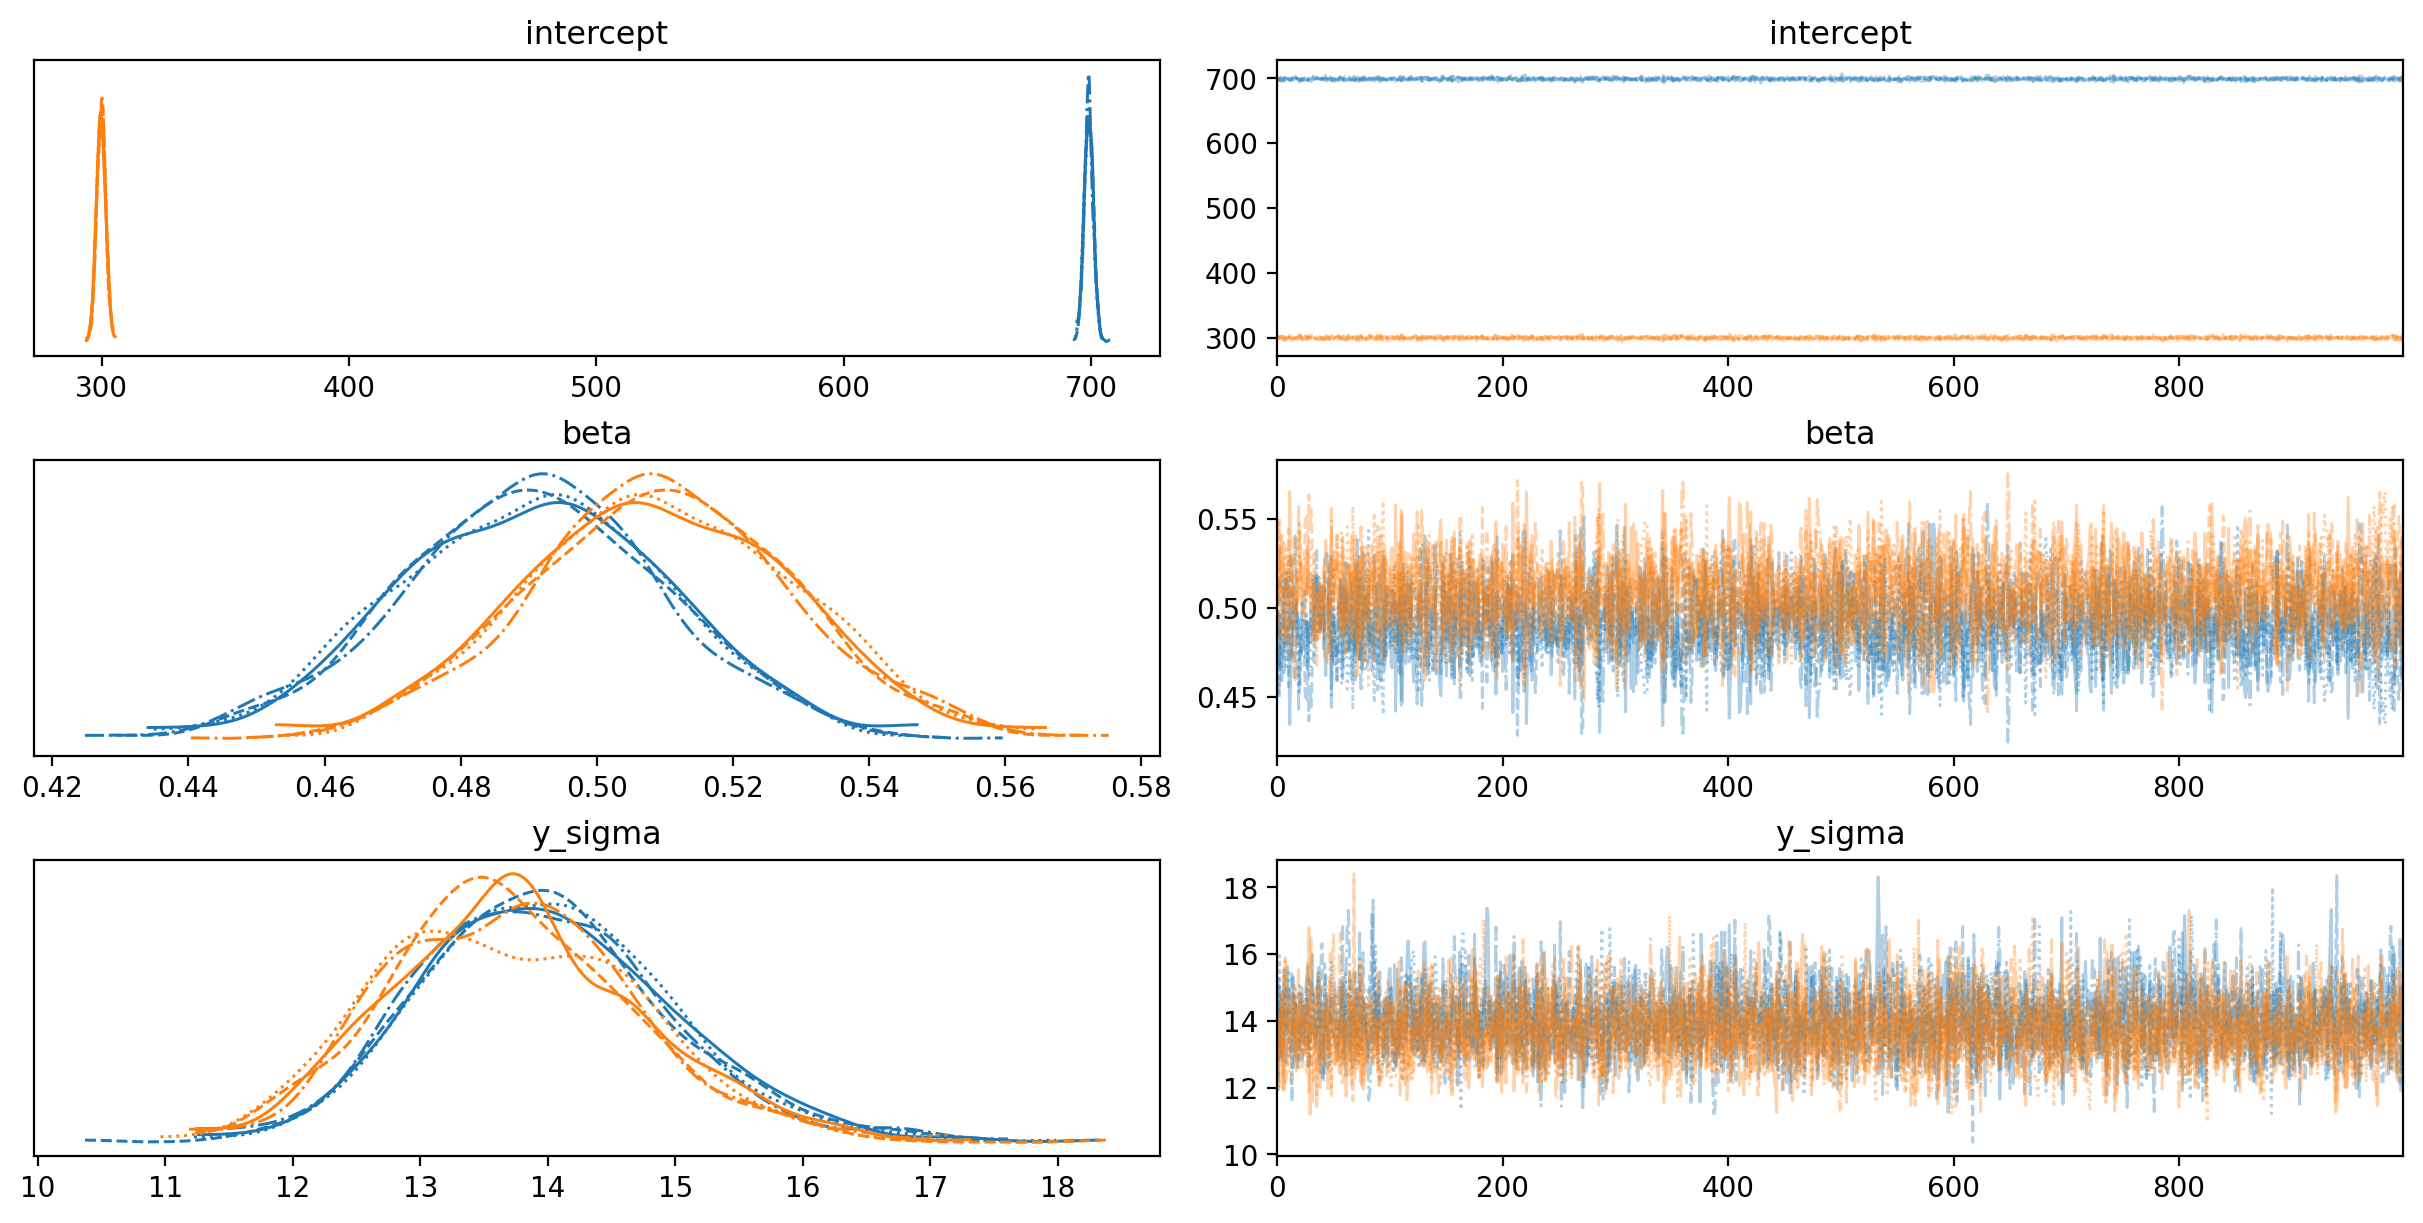

In [12]:
az.plot_trace(model1.idata, var_names="~mu");

And seeing as this is our first encounter with the MV-ITS model, let's compare the prior and posteriors of the model parameters.

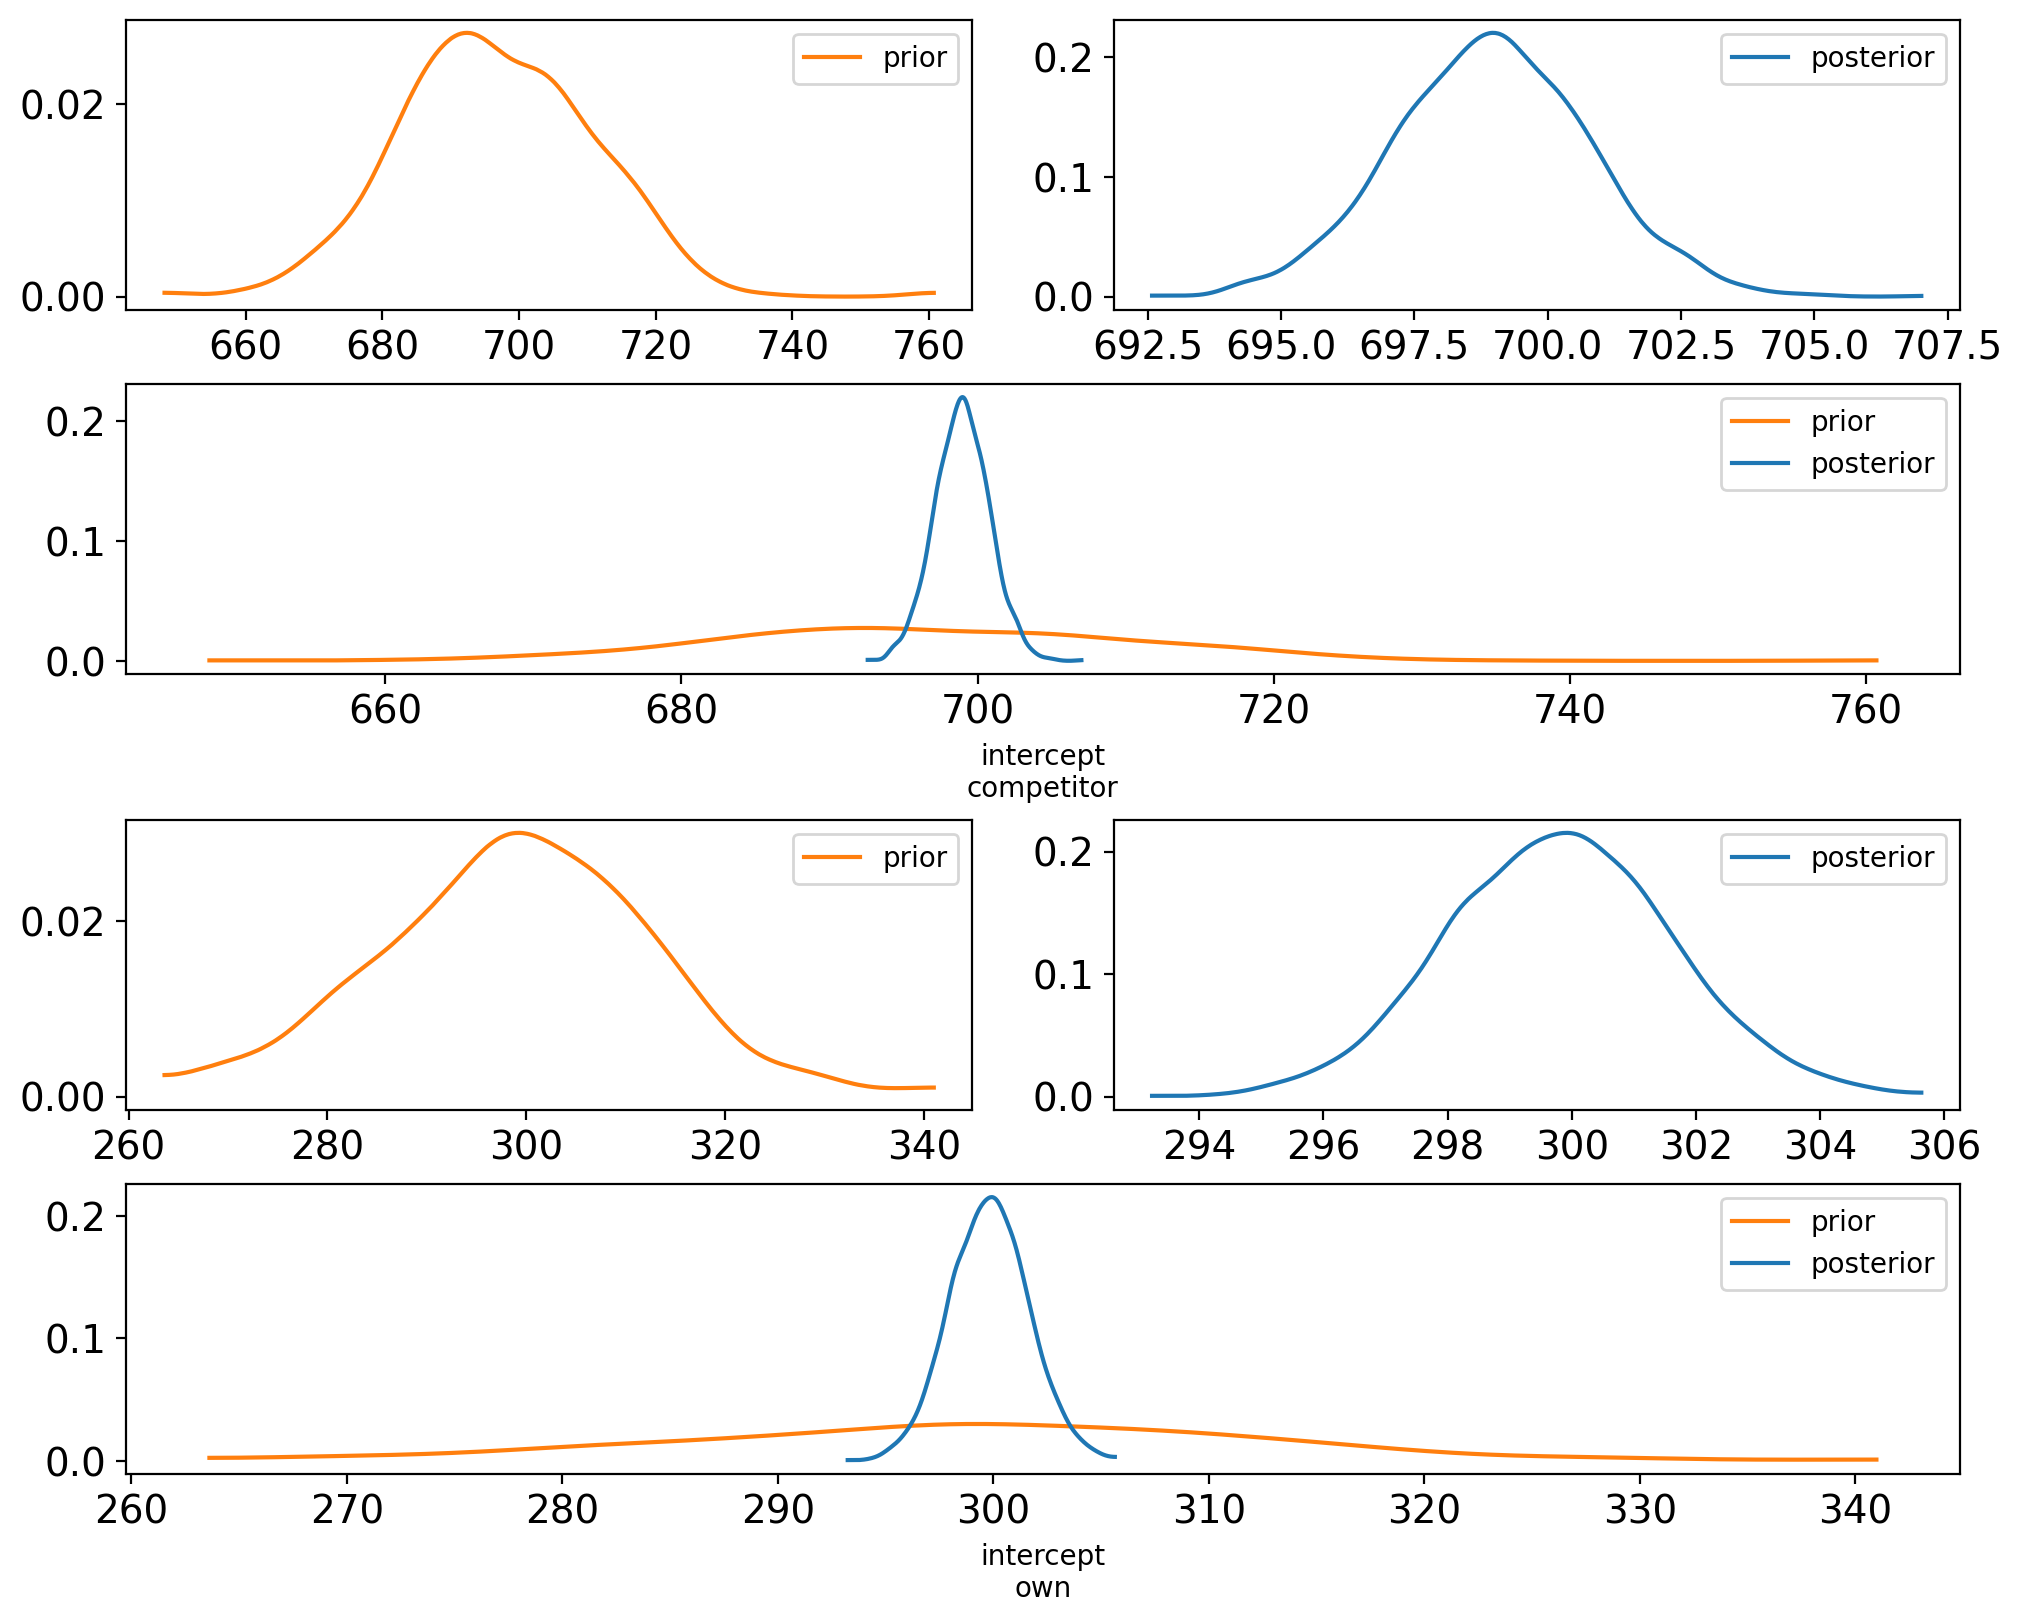

In [13]:
az.plot_dist_comparison(model1.idata, var_names="intercept", figsize=(10, 8));

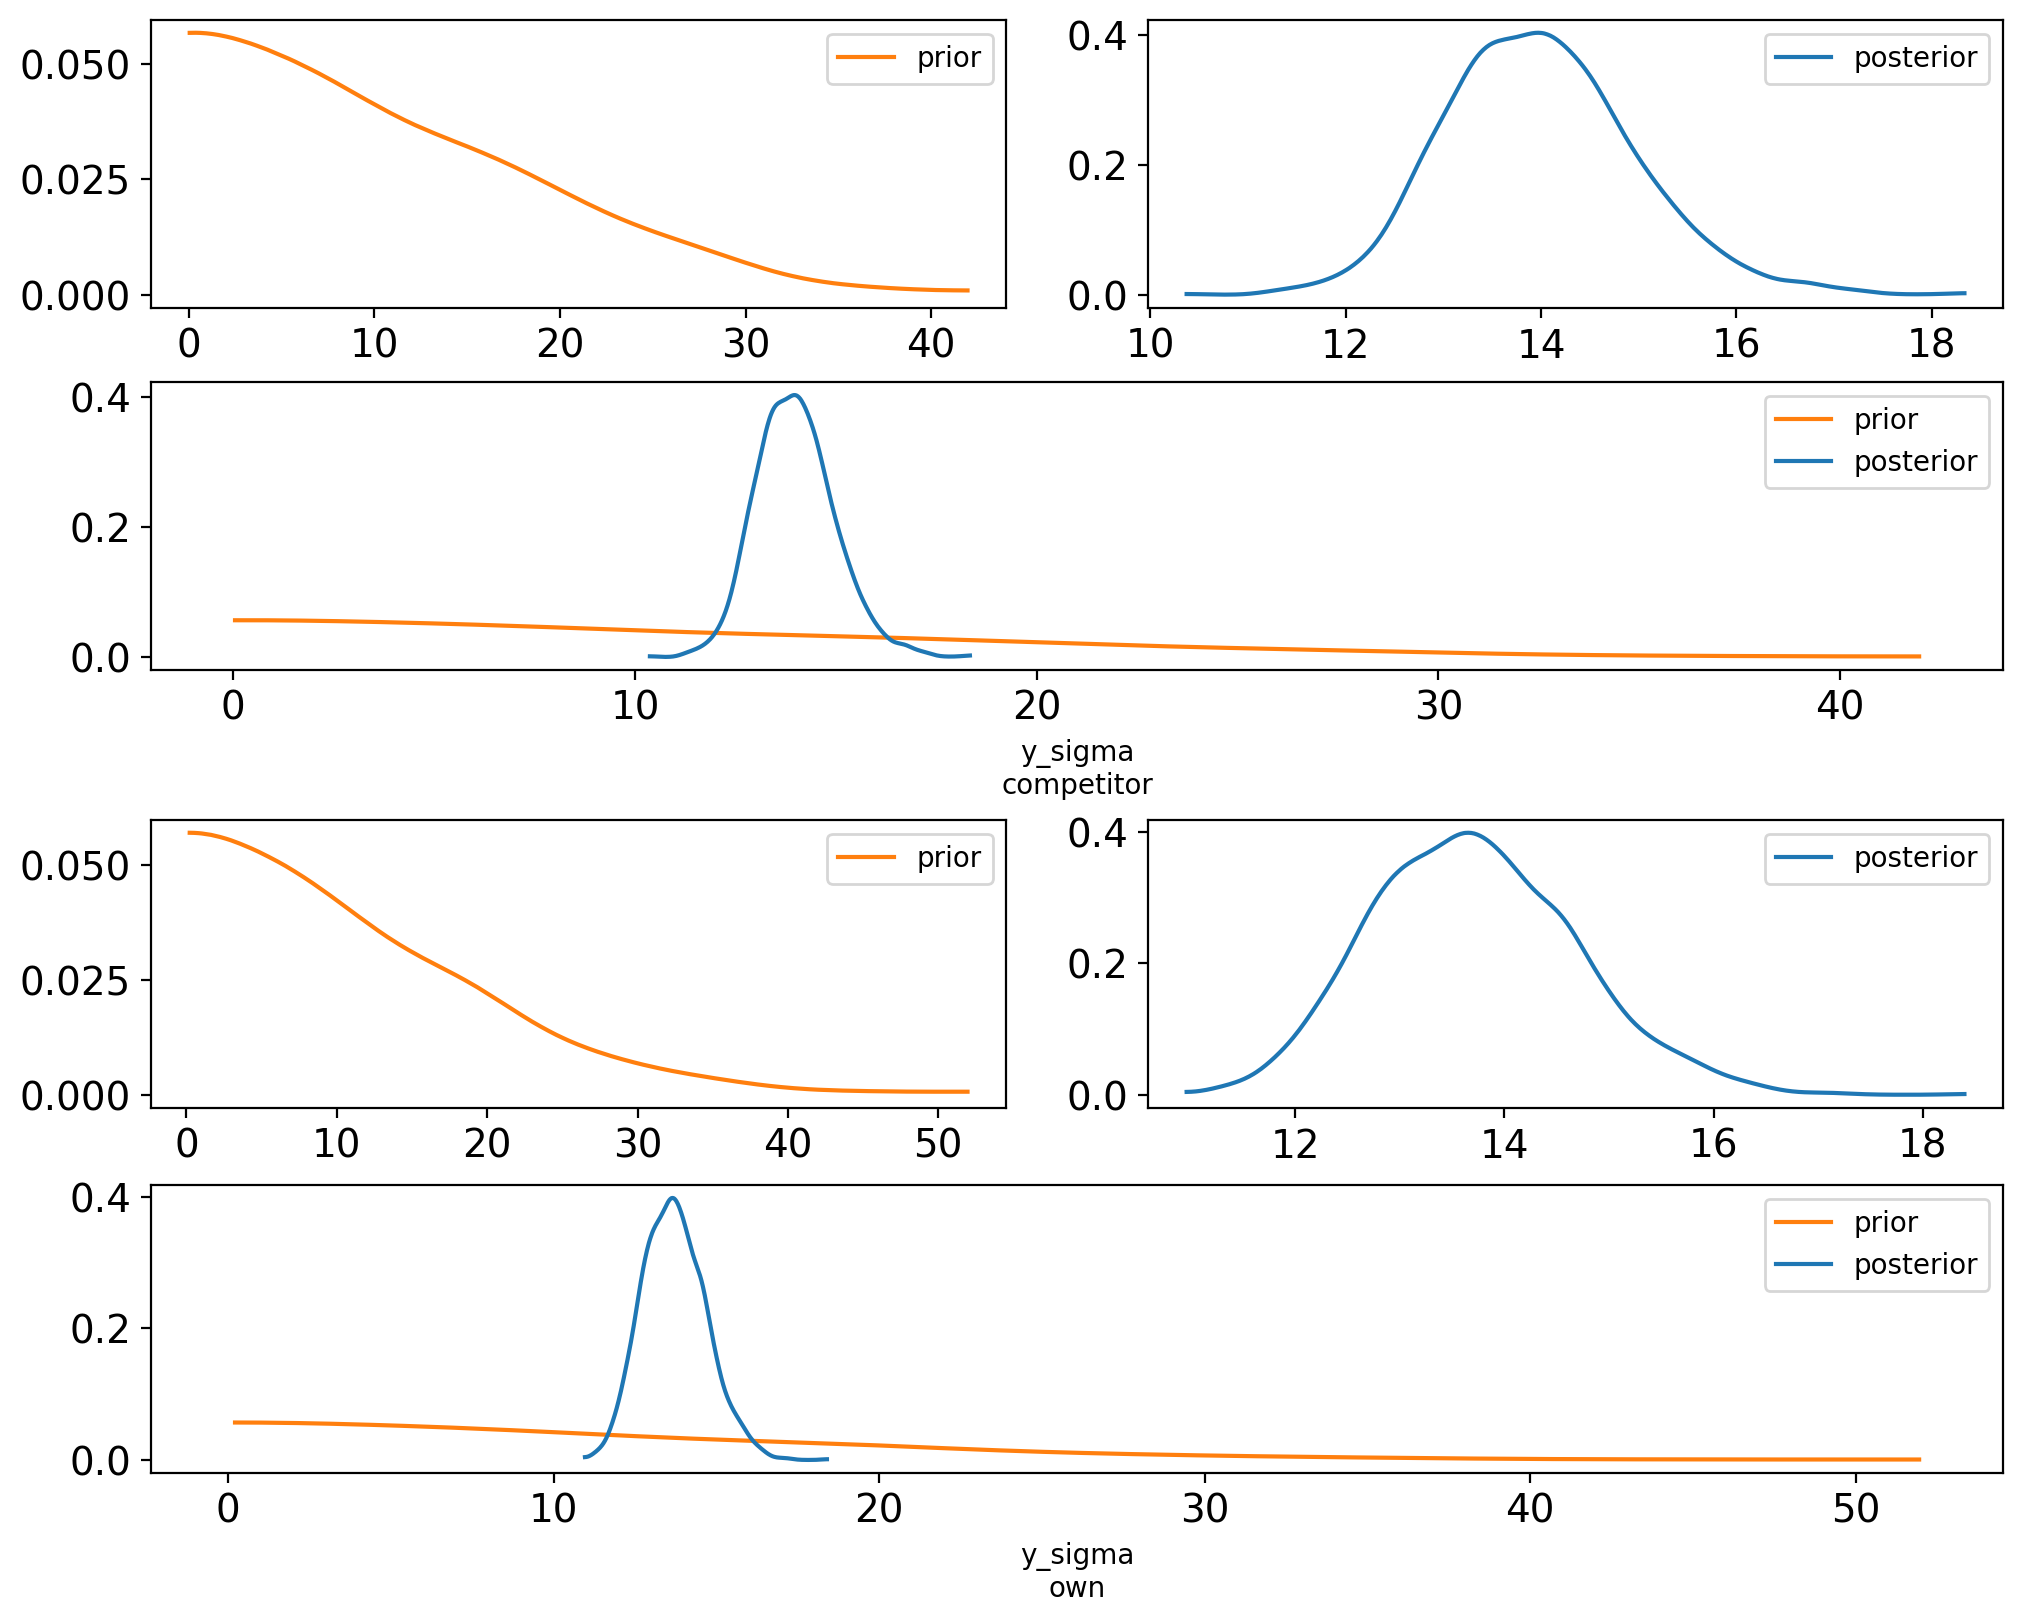

In [14]:
az.plot_dist_comparison(model1.idata, var_names="y_sigma", figsize=(10, 8));

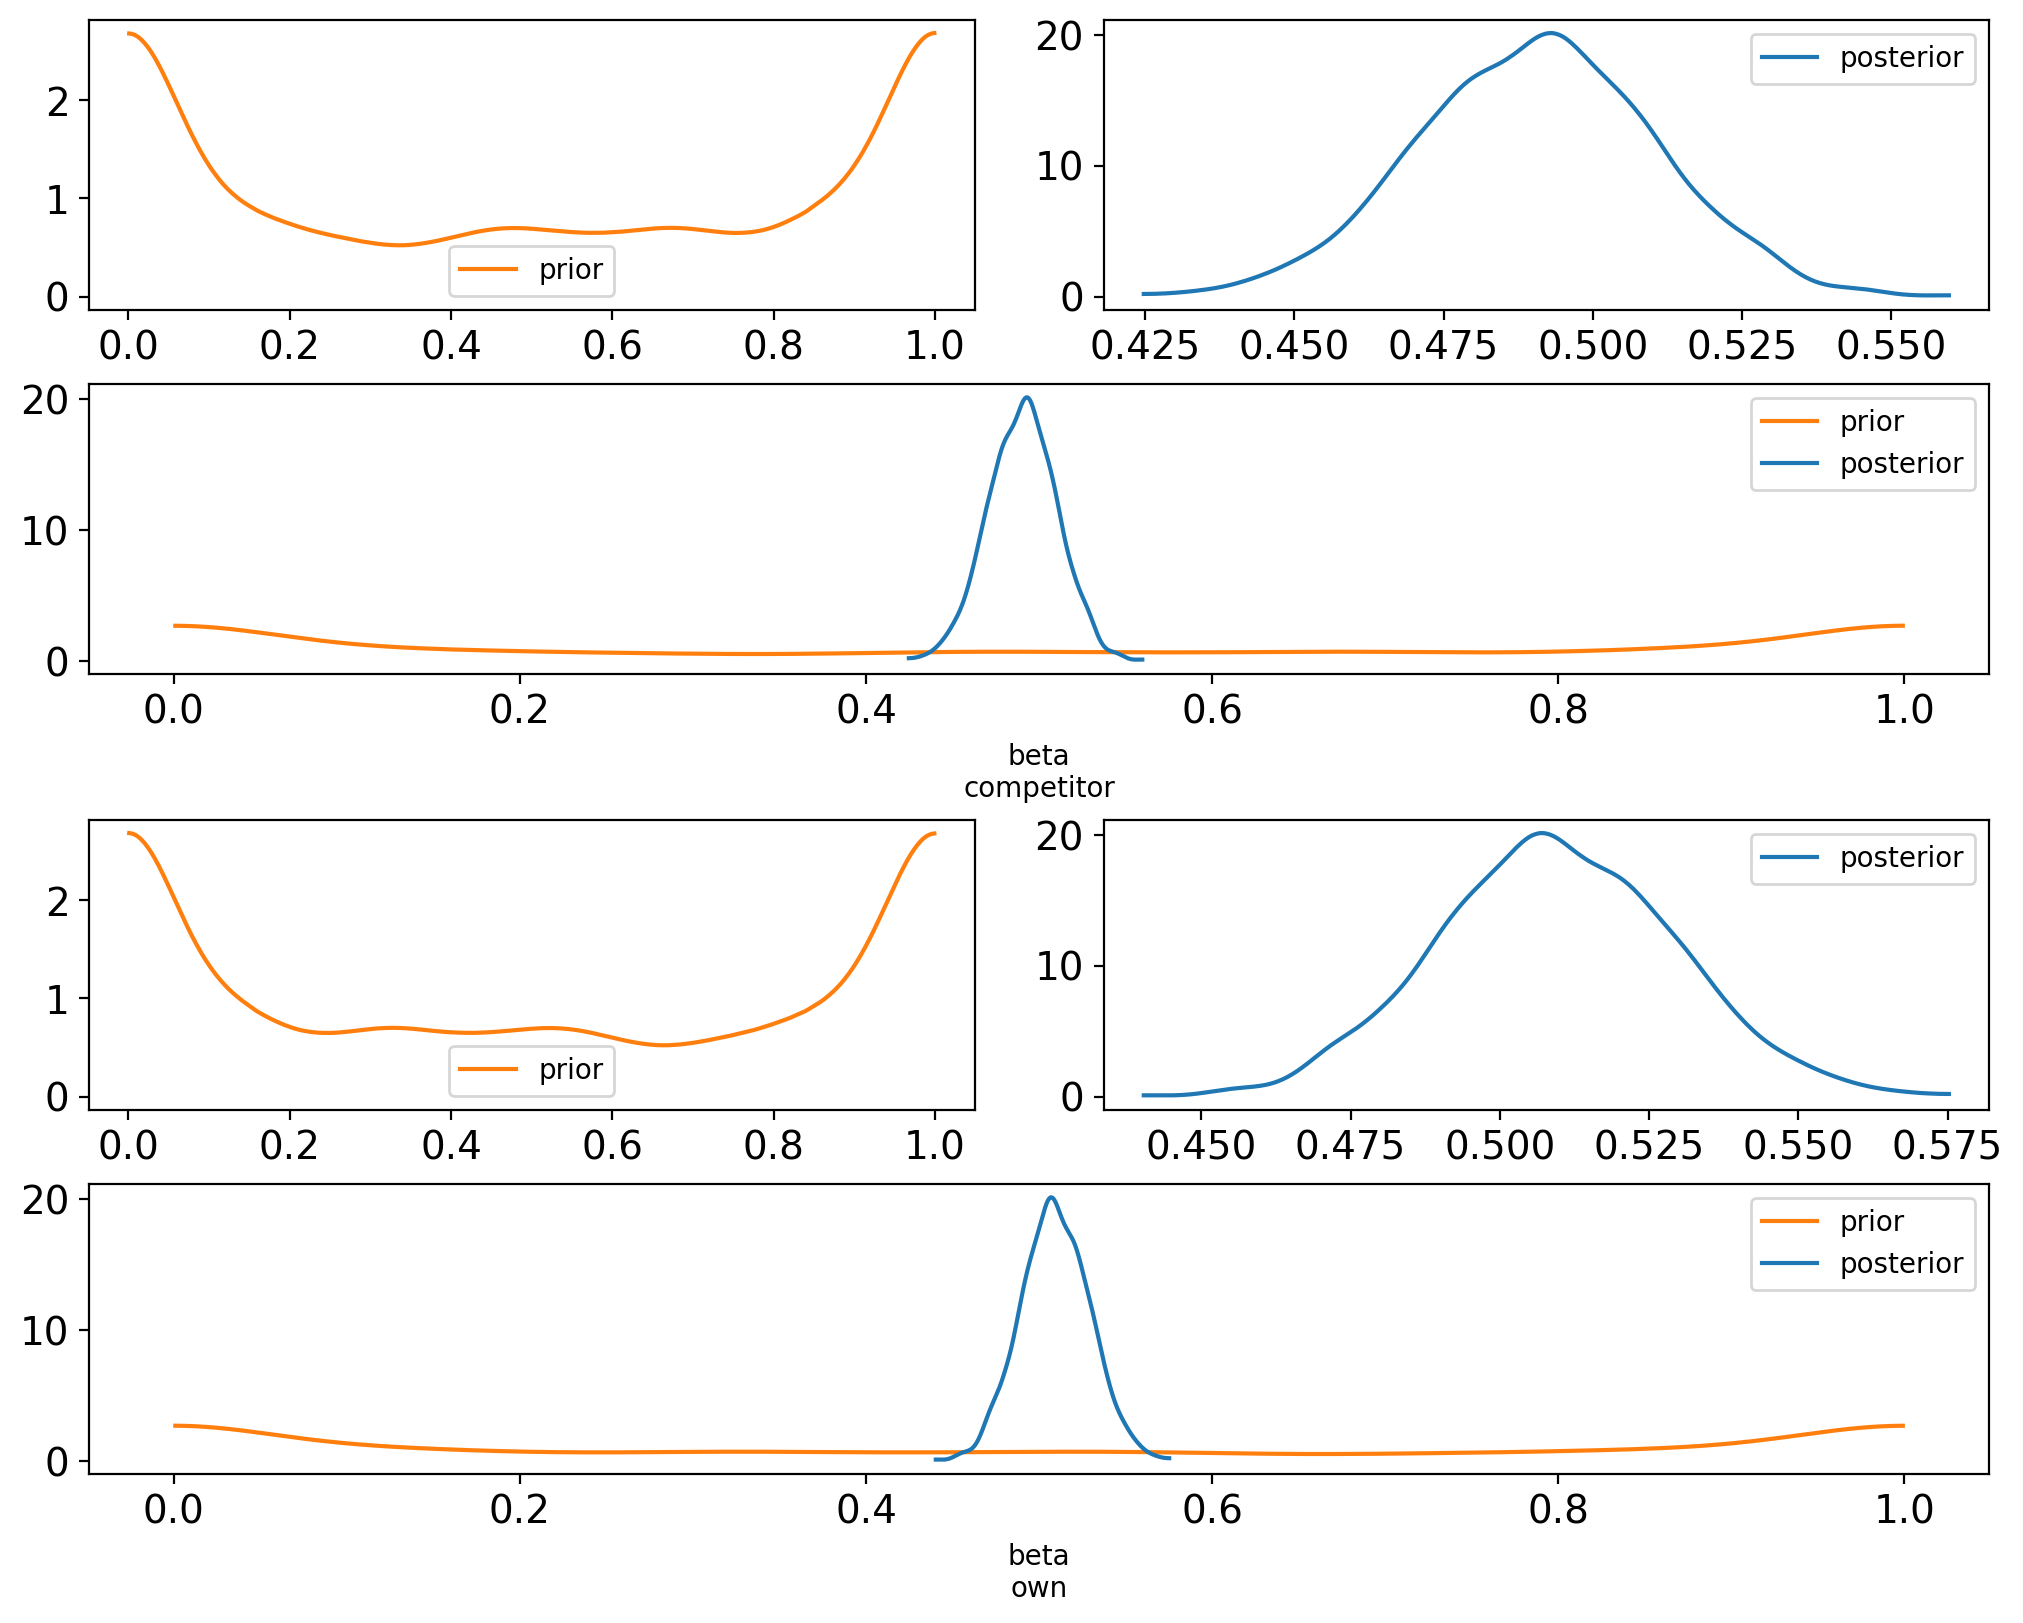

In [15]:
az.plot_dist_comparison(model1.idata, var_names="beta", figsize=(10, 8));

### Model results

Let's (visually) evaluate to what extent the model can account for the sales data by plotting posterior predictive fits. The plot below looks pretty good - we can see that the model predictions (shaded regions) capture the main properties of the actual sales data, namely the step change at the time of the new product introduction.

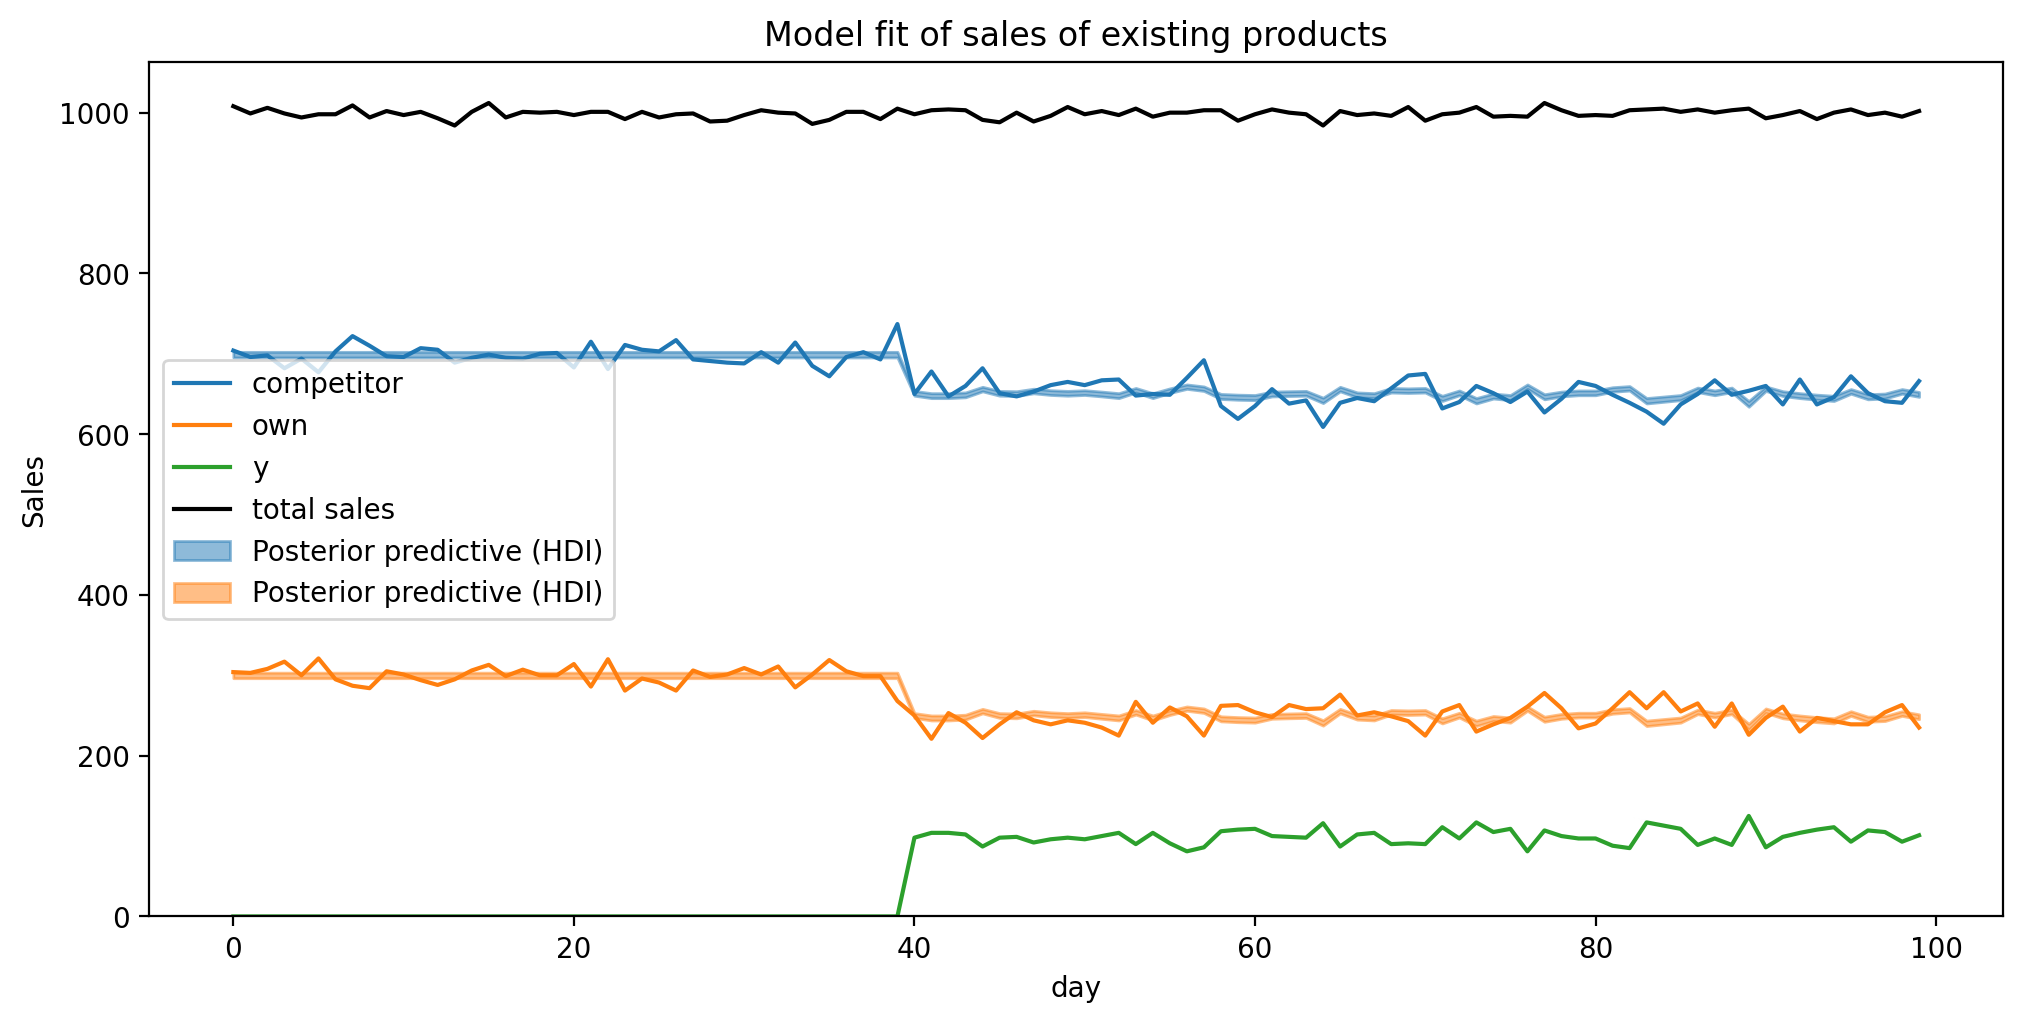

In [16]:
model1.plot_fit();

Now let's look at the model's predicted sales in the counterfactual scenario where the company did not launch the new product. We can evaluate this visually to see if the counterfactual scenario makes sense. In this ultra-simplified example it is easy to evaluate this as a "yes". The model predicts what we would intuitively expect, that the own and competitor sales would have continued as they were prior to the new product launch.

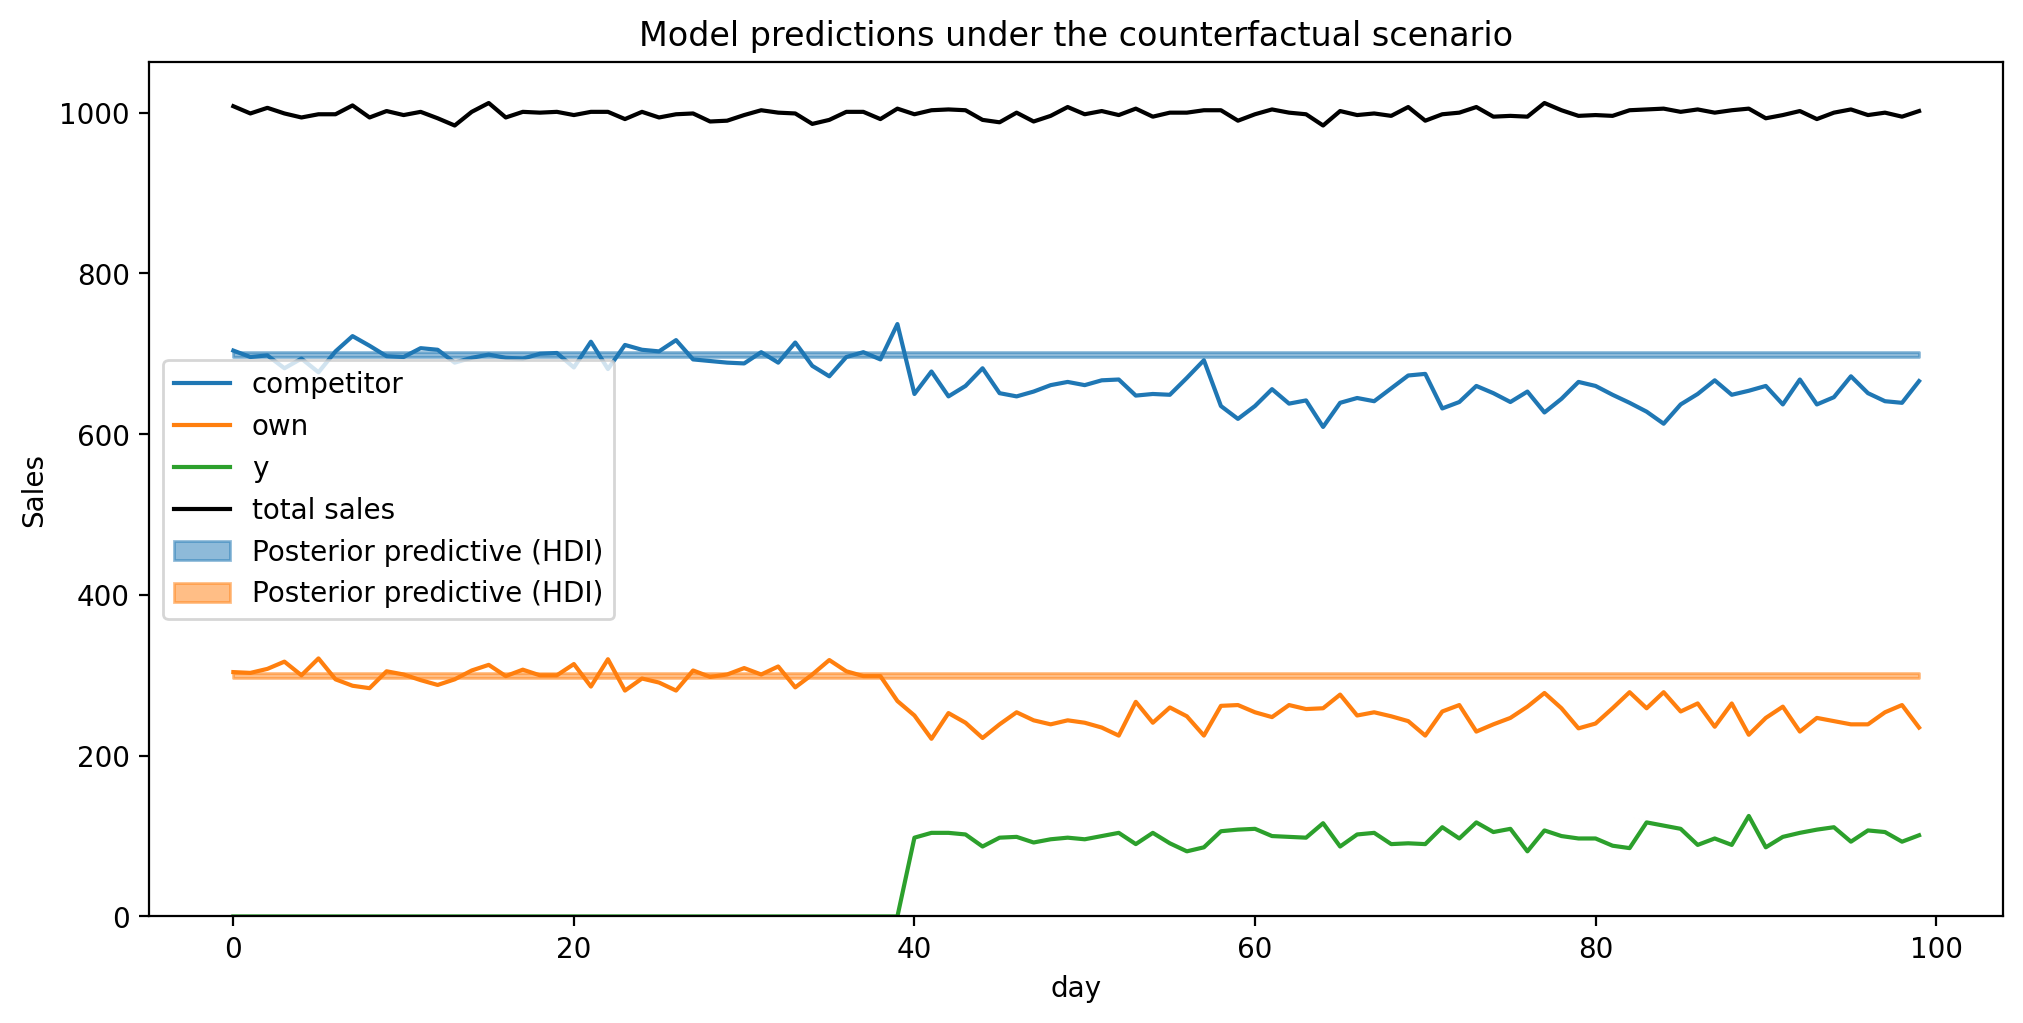

In [17]:
model1.plot_counterfactual();

```{admonition} Counterfactual scenario of not releasing the new product
:class: note

The counterfactual scenario is evaluated by setting the sales of the new product (using PyMC's `do` operator) to zero in the model's input data. We then run posterior predictive sampling to see how the expected and actual sales counts are affected by this intervention in the causal graph.
```

By comparing the two (the model predictions in the _actual_ and the _counterfactual_ scenarios), we have our estimated causal impacts upon each of the existing products of the new product launch. Here we can see that both own and competitor sales were reduced by the launch of the new product sales. So the model is attributing the sales of the new product as having come from both own and competitor sales in (approximately) equal amounts.

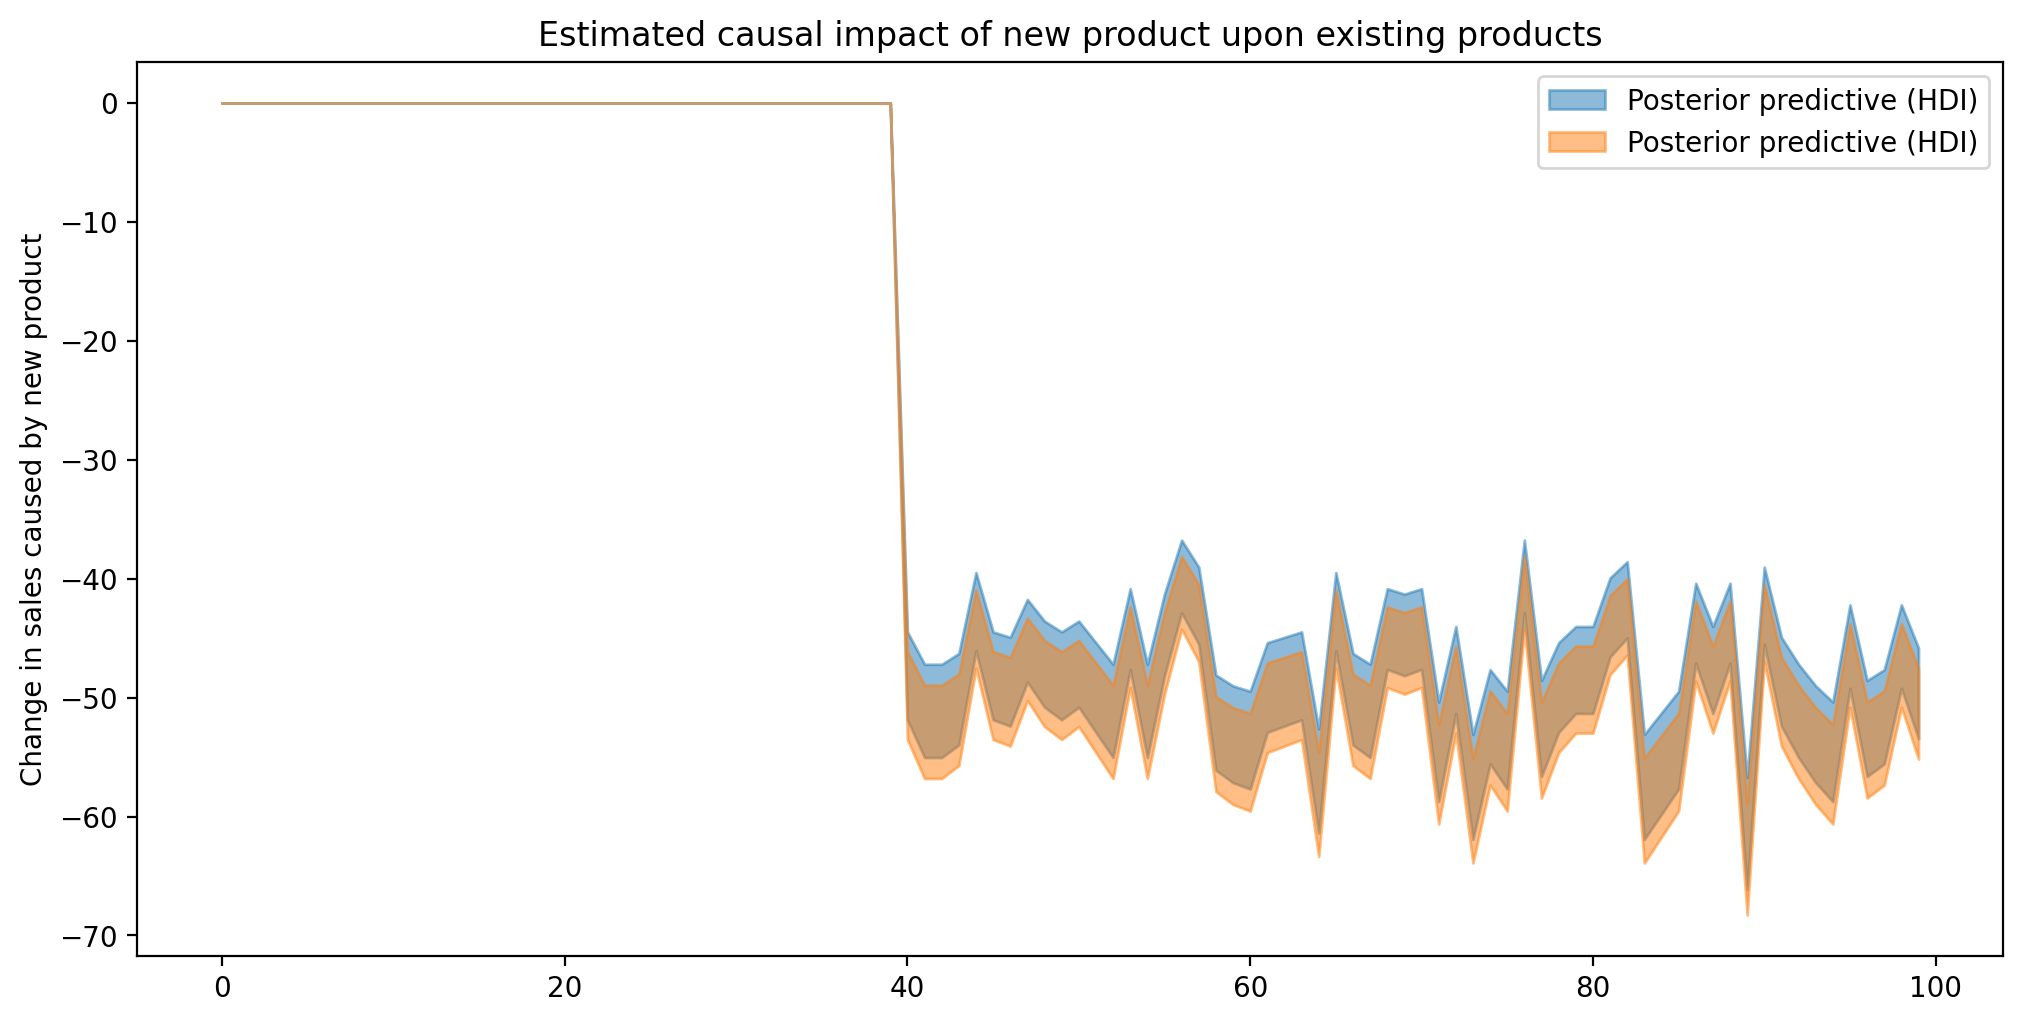

In [18]:
model1.plot_causal_impact_sales();

However we can see that it is not exactly 50/50 in terms of sales. In order to look more precisely, we can examine the $\beta$ parameters. 

* The `beta[competitor]` coefficient represents the proportion of sales of the new product which came from competitor sales. So this represents the incrementality in terms of sales (not market share).
* The `beta[own]` coefficient represents the proportion of sales of the new product which came from your own sales.

We can see that the 94% credible intervals are relatively tight and are roughly centered on 50/50. So practically we may conclude that we have approximately 50% incrementality, 50% cannibalization.

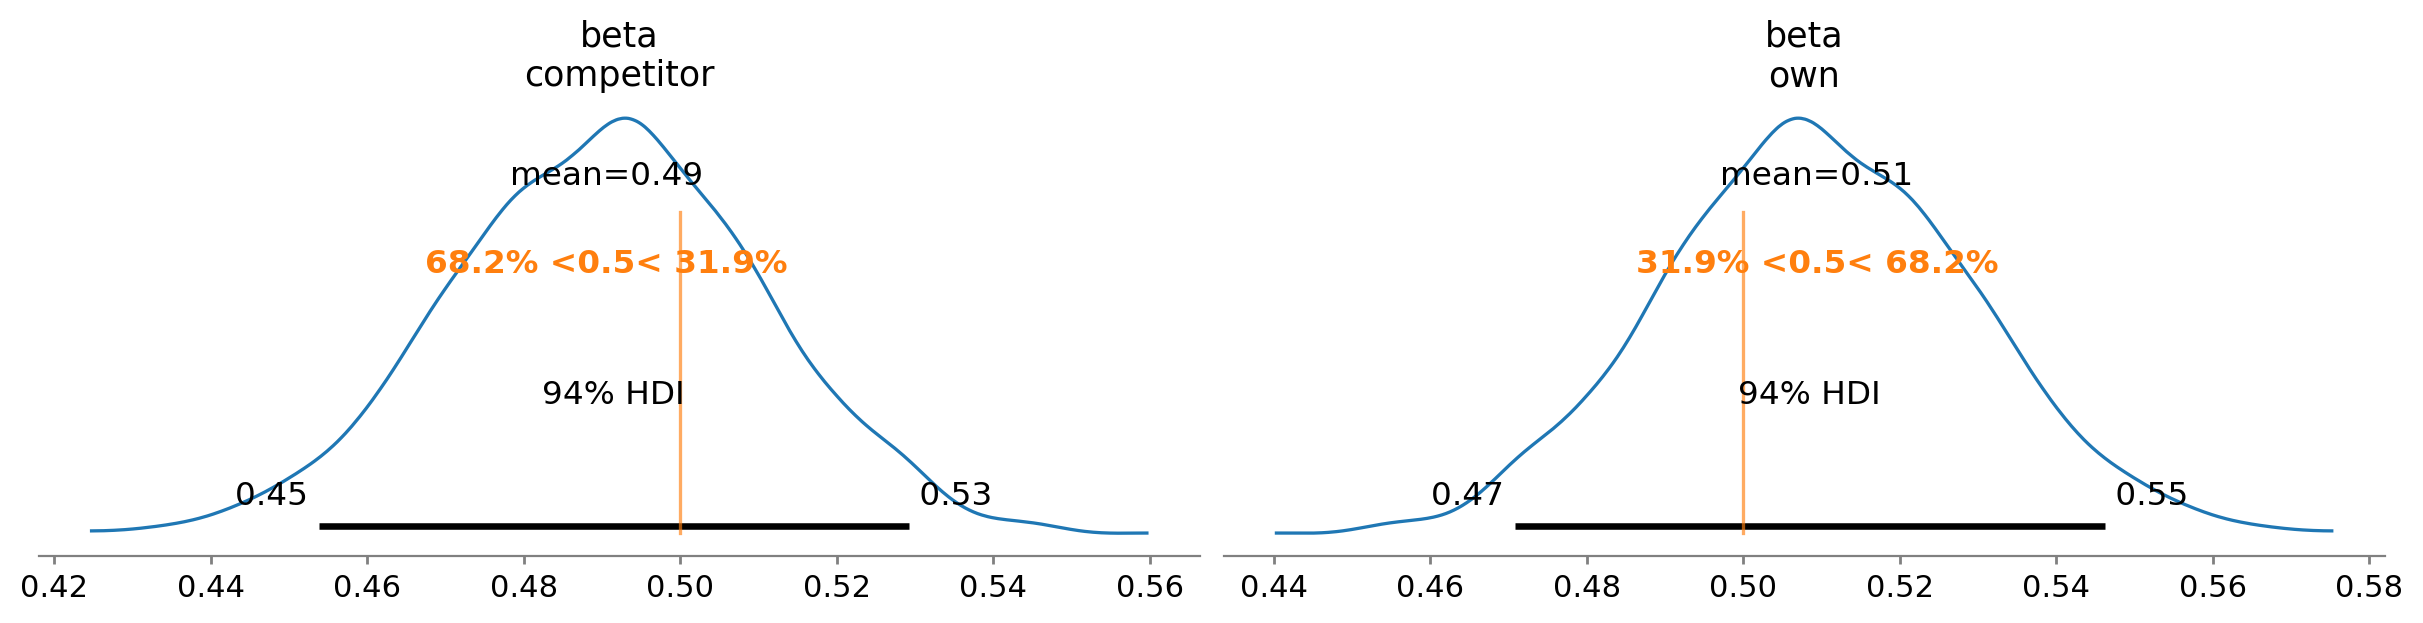

In [19]:
az.plot_posterior(
    model1.idata,
    var_names=["beta"],
    ref_val=0.5,
    textsize=11,
    figsize=(12, 3),
);

```{admonition} Sales versus market share
:class: warning

Remember that the $\beta$ coefficients represent the proportion of _sales_ of the new product which are attributable to competitor and own product sales.
```

We can also plot this in 'market share space'. In this example with stable total sales the plot looks similar to above. But this need not be the case in more general scenarios, so being able to plot the causal impact both in terms of sales and in terms of market share is useful.

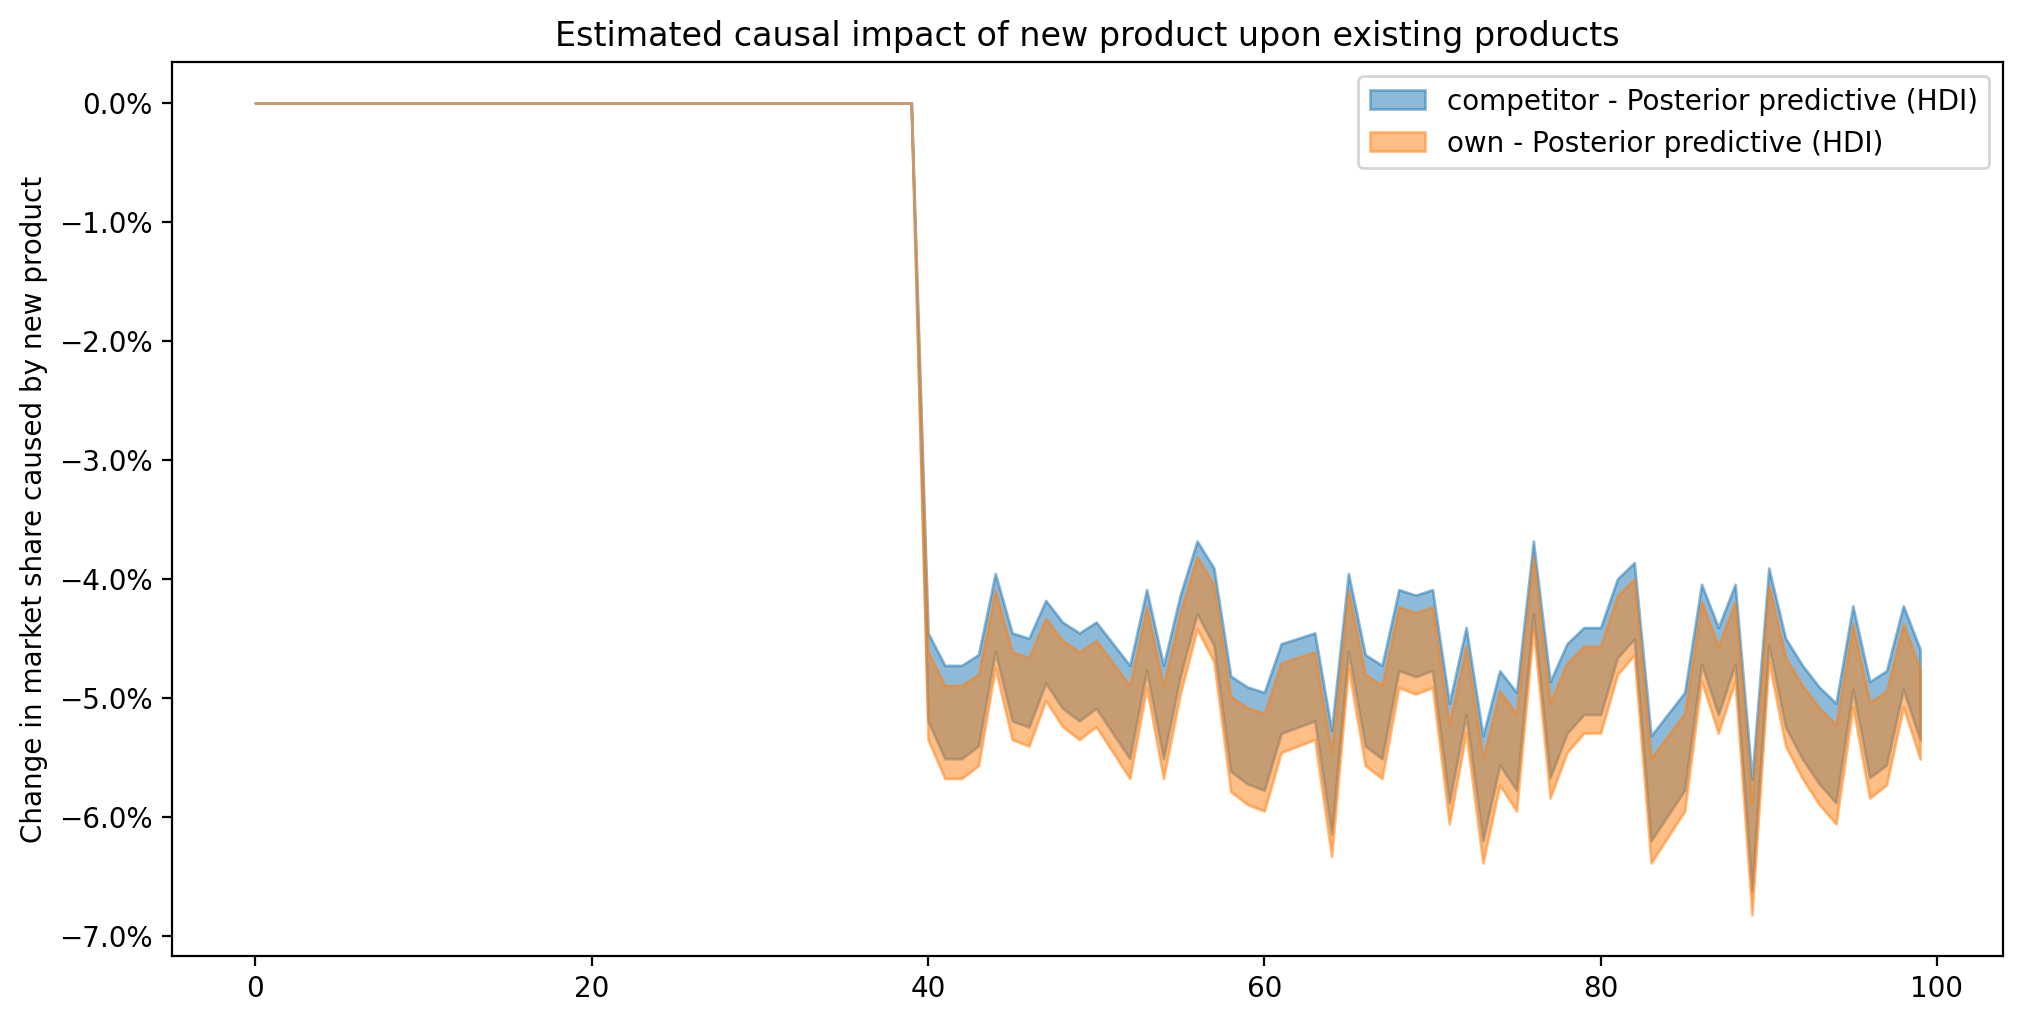

In [20]:
model1.plot_causal_impact_market_share();

## Scenario 2 - high total sales variability

This scenario is exactly the same as the previous, except for having much greater variability in total sales figures. We will not run through all the steps in the same level of detail as above because the main focus is to examine the effects of increased variability in total sales.

In [21]:
scenario2 = scenario1.copy()
scenario2["total_sales_sigma"] = 80

data = generate_saturated_data(**scenario2)

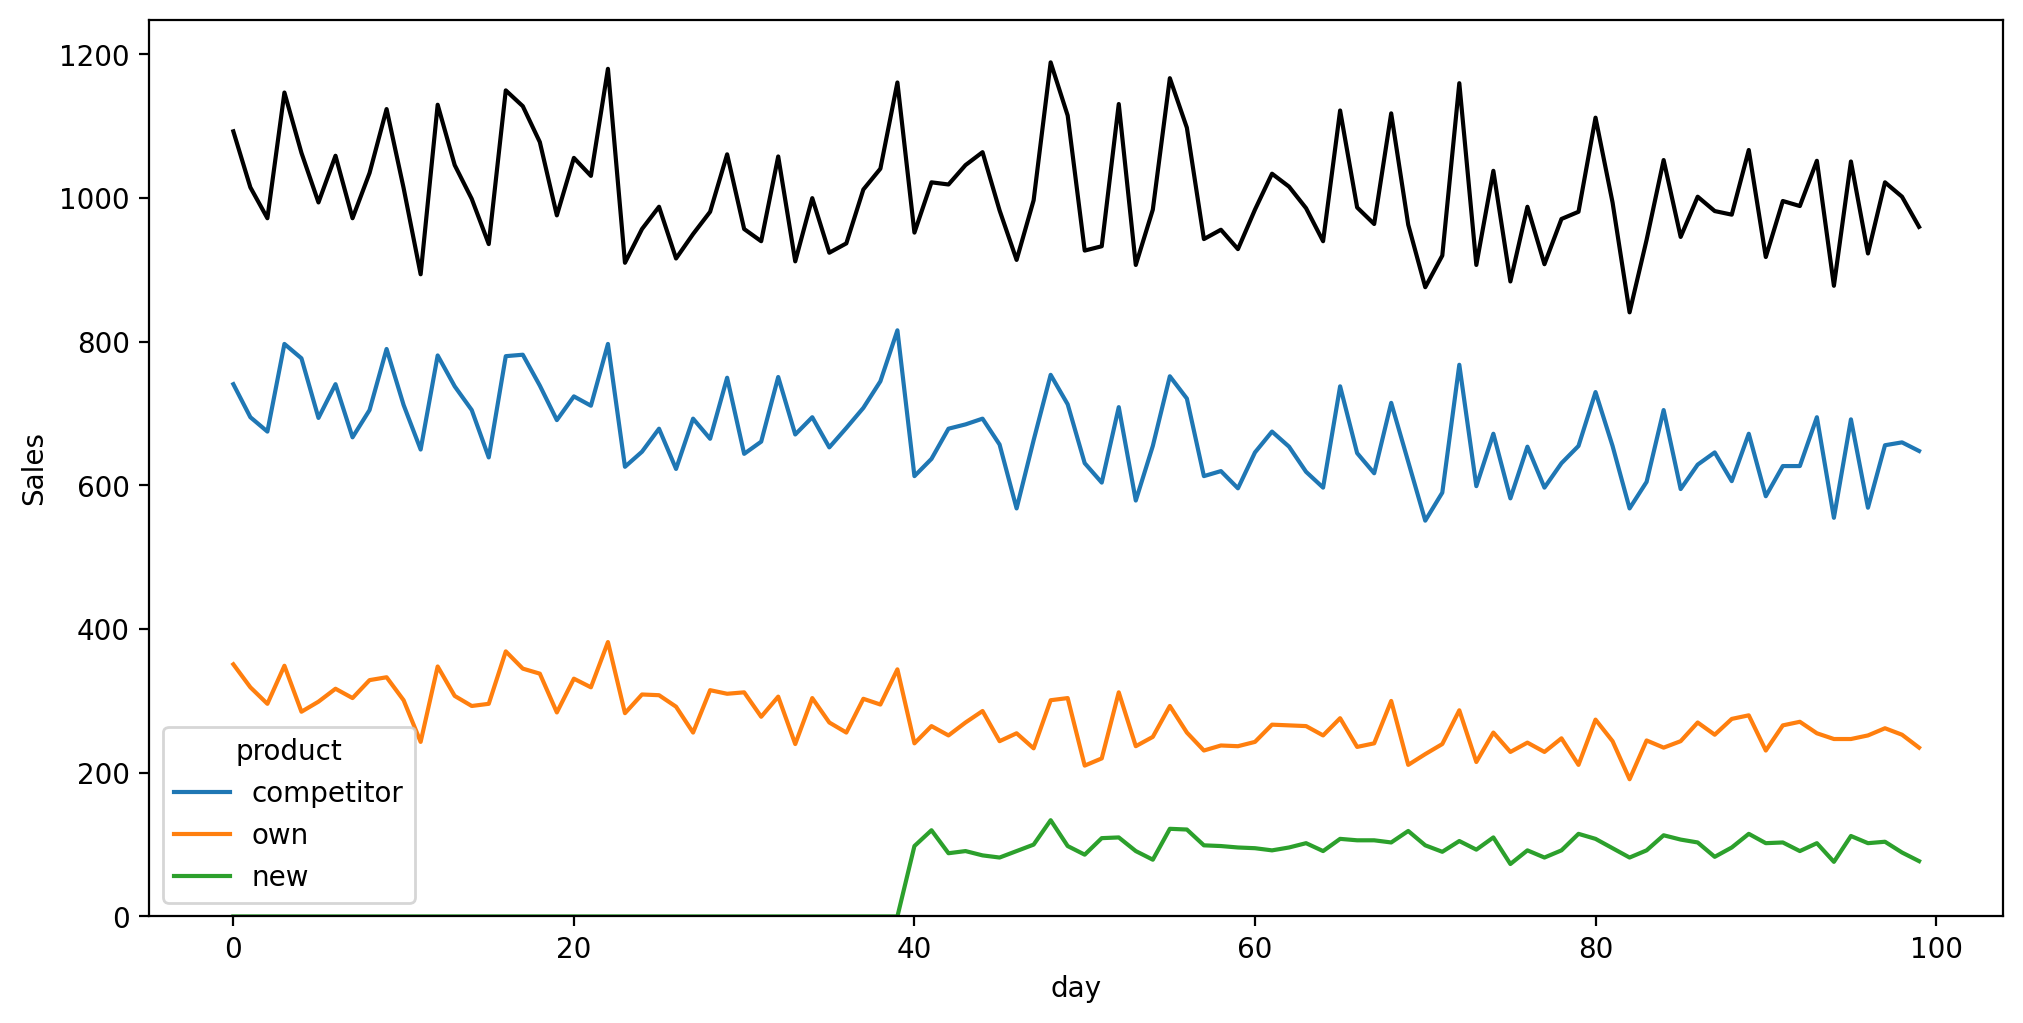

In [22]:
ax = plot_product(data);

Let's take a look at the relationships between the new product sales and the own and competitor sales. In comparison to the first scenario, we now see positive correlations. This might be a bit of a warning sign because it runs counter to the assumption of the model - when new sales are higher the own and competitor sales are lower. 

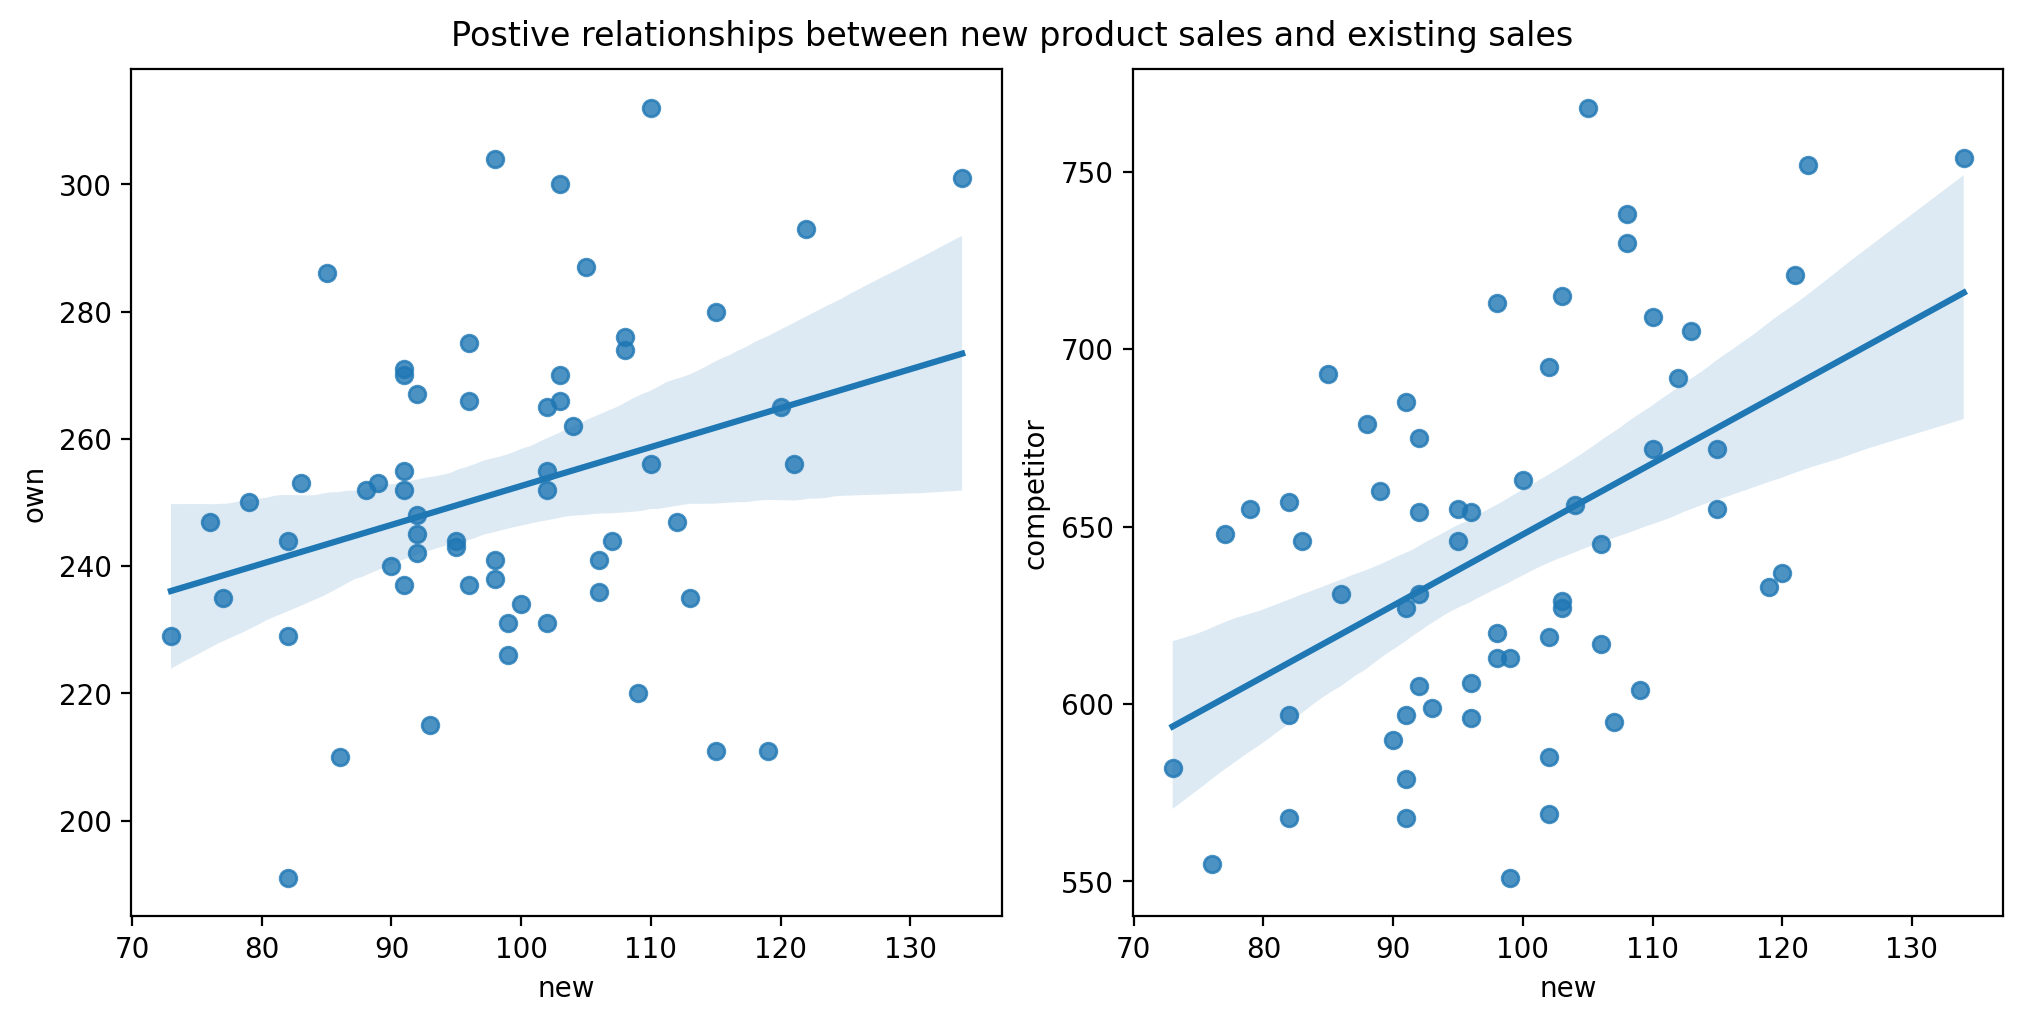

In [23]:
fig, ax = plt.subplots(1, 2)
sns.regplot(data=data.query("pre == False"), x="new", y="own", ax=ax[0])
sns.regplot(data=data.query("pre == False"), x="new", y="competitor", ax=ax[1])
plt.suptitle("Postive relationships between new product sales and existing sales");

Why is this happening? For any given point in time, because own and competitor sales are drawn from a multinomial distribution, we would expect the empirical sales counts to reflect the (unchanging in this example) latent market shares. However, the high variability in total sales induces a positive correlation in sales counts. On days where there are more total sales, there tends to be more new product sales and more own and competitor sales.

This need not mean that the model is dead in the water, but it does highlight a potential mismatch between the data generating process and the MVITS model. But let's fit the model and see if it's estimates are reasonable.

As we said, this is a forewarning of potential problems. Let's see how this pans out by applying the MVITS model to the data.

In [24]:
model2 = MVITS(
    existing_sales=["competitor", "own"],
    saturated_market=True,
)
model2.inform_default_prior(
    data=data.loc[: scenario2["treatment_time"], model2.existing_sales],
)

model2.sample(data.loc[:, model2.existing_sales], data["new"]);

Sampling: [beta, intercept, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

So how does the model do? Plotting the causal impact of the new product upon the sales of the existing products looks reasonable. This is primarily because the changes in sales caused by the new product are roughly equally split between the competitor and own sales, and this is how we set up the simulated data. However, compared to the first example we can see a much greater level of uncertainty in the causal impacts of the new product.

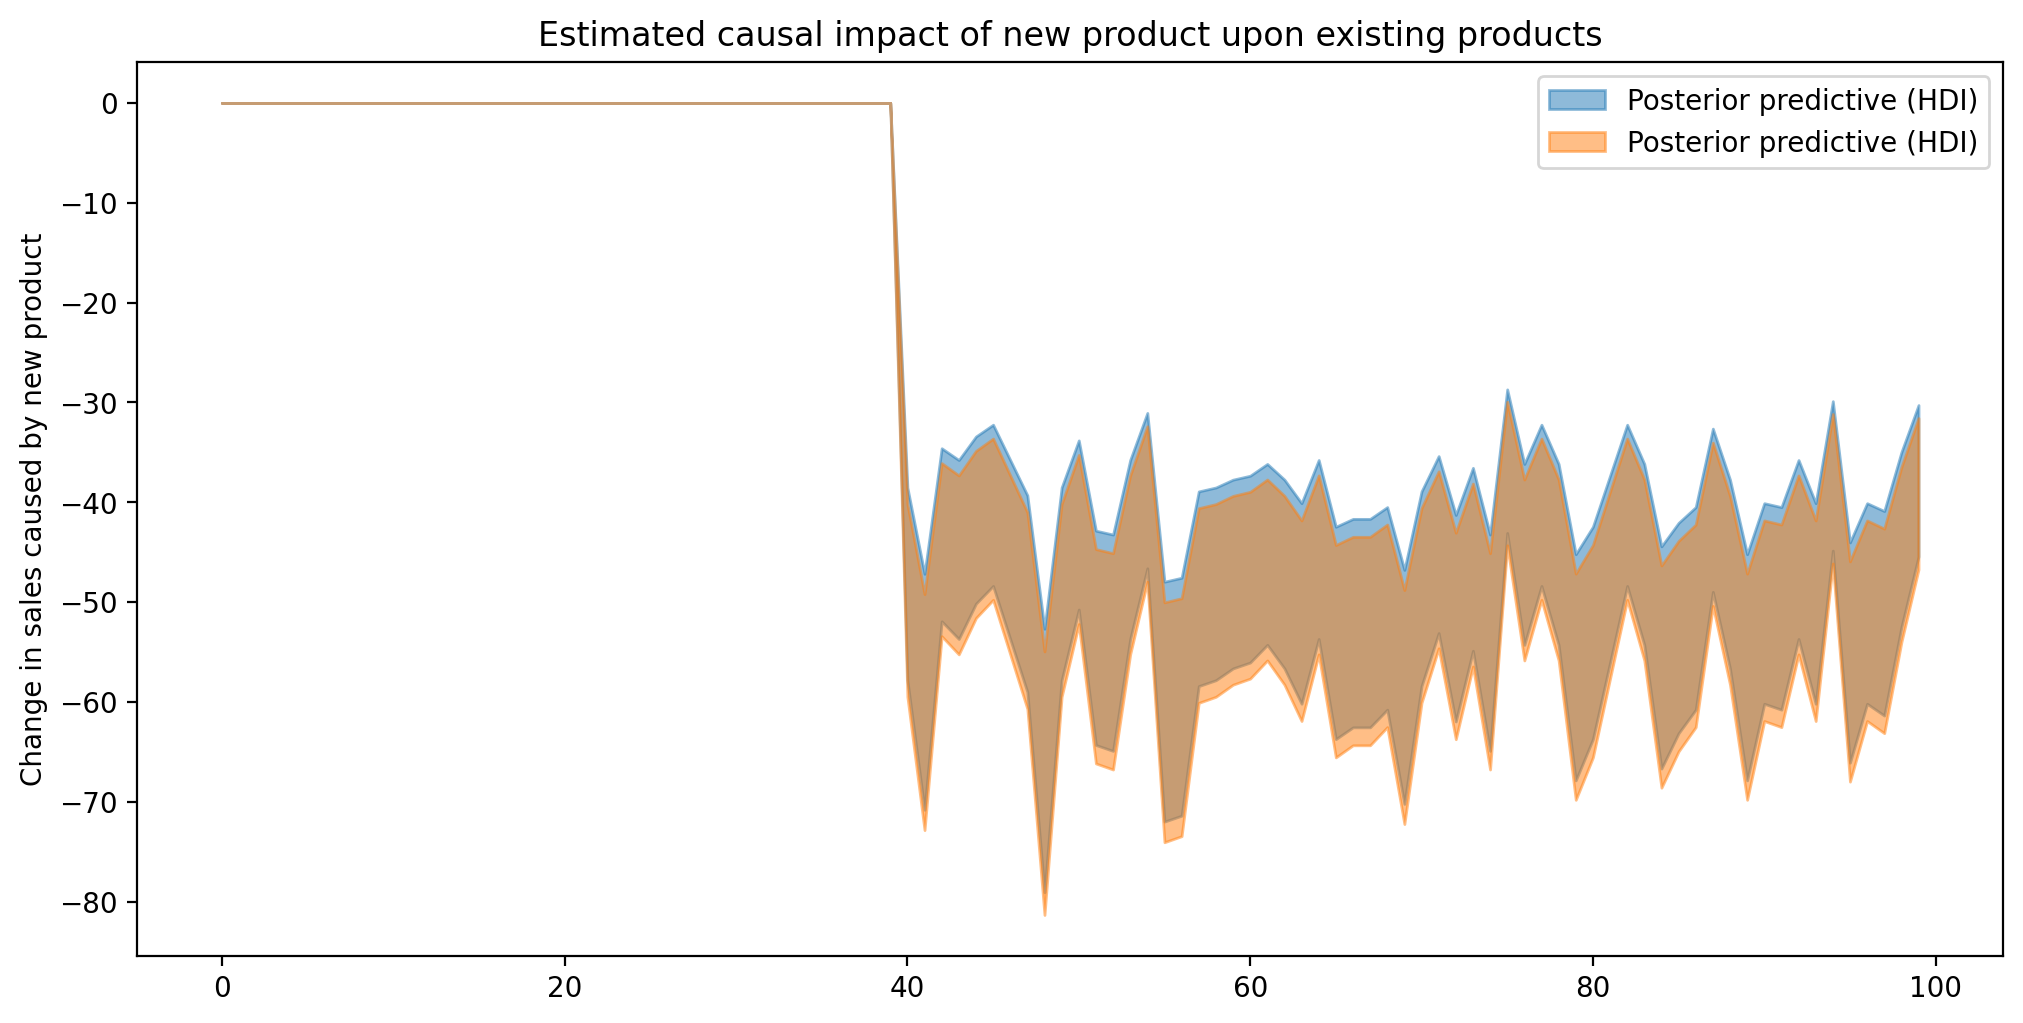

In [25]:
model2.plot_causal_impact_sales();

This can be seen quantitatively by examining the $\beta$ weights. The 94% credible intervals of the relative contribition of new product sales to the competitor and own sales are much broader, at roughly $\pm 10\%$.

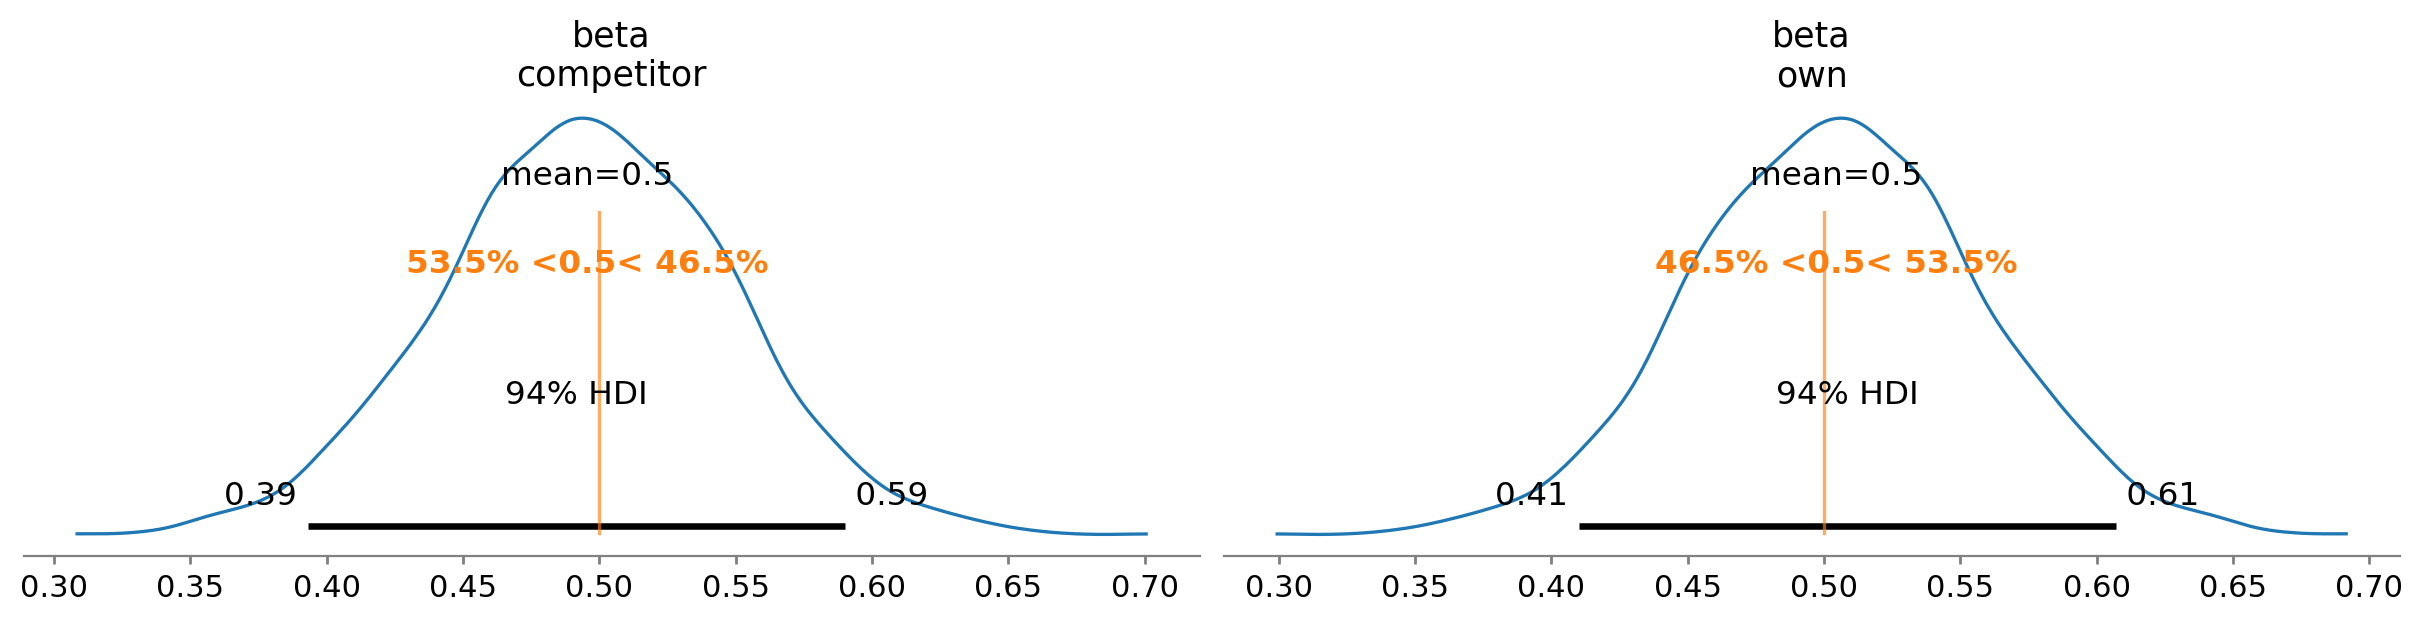

In [26]:
az.plot_posterior(
    model2.idata, var_names=["beta"], ref_val=0.5, textsize=11, figsize=(12, 3)
);

So far, we've seen that for pretty simple synthetic datasets, the MVITS model does a reasonable job inferring the level of incrementality and cannibalization. However, in many situations the model will likely not be robust enough to do well. Scenario 2 has demonstrated this - on the plus side the estimates don't seem to be biased, but the level of uncertainty in the level of cannibalization/incrementality are quite high.

## Scenario 3 - modeling products individually

Now we will expand beyond modeling at the highly aggregated level of "own" and "competitor" sales. We will now model the sales of individual products.

In [27]:
# Create a list of product names. The last product is the new product
products = [f"product{i+1}" for i in range(6)]
products.append("new")

scenario3 = {
    "total_sales_mu": 5000,
    "total_sales_sigma": 20,
    "treatment_time": 40,
    "n_observations": 100,
    "market_shares_before": [[0.1, 0.1, 0.15, 0.2, 0.2, 0.25, 0.0]],
    "market_shares_after": [[0.07, 0.08, 0.15, 0.2, 0.18, 0.22, 0.1]],
    "market_share_labels": products,
    "rng": rng,
}

data = generate_saturated_data(**scenario3)
data.head()

product  product1  product2  product3  product4  product5  product6  new   pre
day                                                                           
0             546       475       708      1028       986      1240    0  True
1             525       515       768       955      1025      1224    0  True
2             526       520       699      1057      1027      1200    0  True
3             533       497       731      1072       954      1205    0  True
4             487       534       776      1028       975      1187    0  True

So let's visualize the sales data. We can see that the sales of the new product are quite high, and that the sales of _some_ of the existing products have decreased.

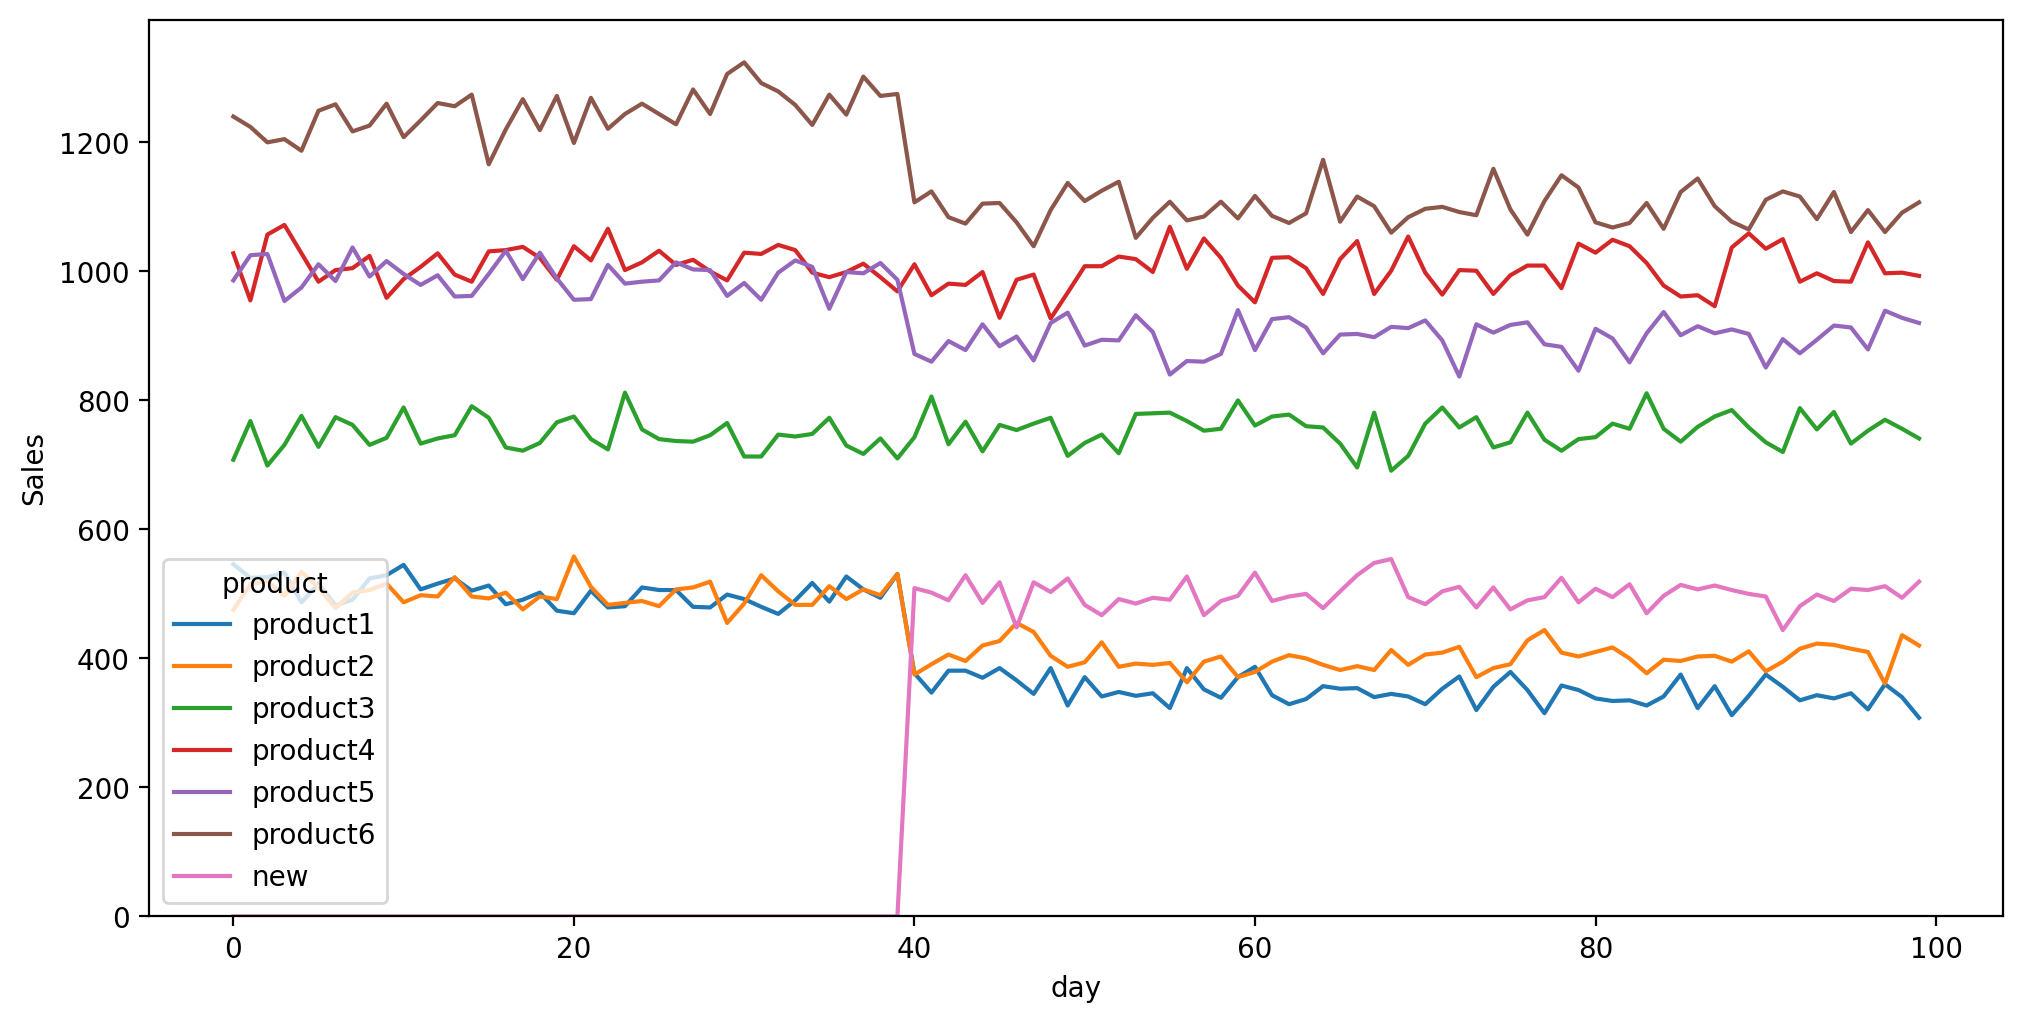

In [28]:
ax = plot_product(data, plot_total_sales=False)

So let's run the analysis. This time we will provide optional kwargs for the sampling process.

In [29]:
fit_kwargs = {"target_accept": 0.95}

model3 = MVITS(
    existing_sales=products[:-1],
    saturated_market=True,
)
model3.inform_default_prior(
    data=data.loc[: scenario3["treatment_time"], model3.existing_sales],
)
model3.sample(data[model3.existing_sales], data["new"], fit_kwargs=fit_kwargs);

Sampling: [beta, intercept, y, y_sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 81 seconds.
Sampling: [y]


Output()

Sampling: [y]


Output()

There aren't any reported issues in the sampling process, and the chains look well mixed.

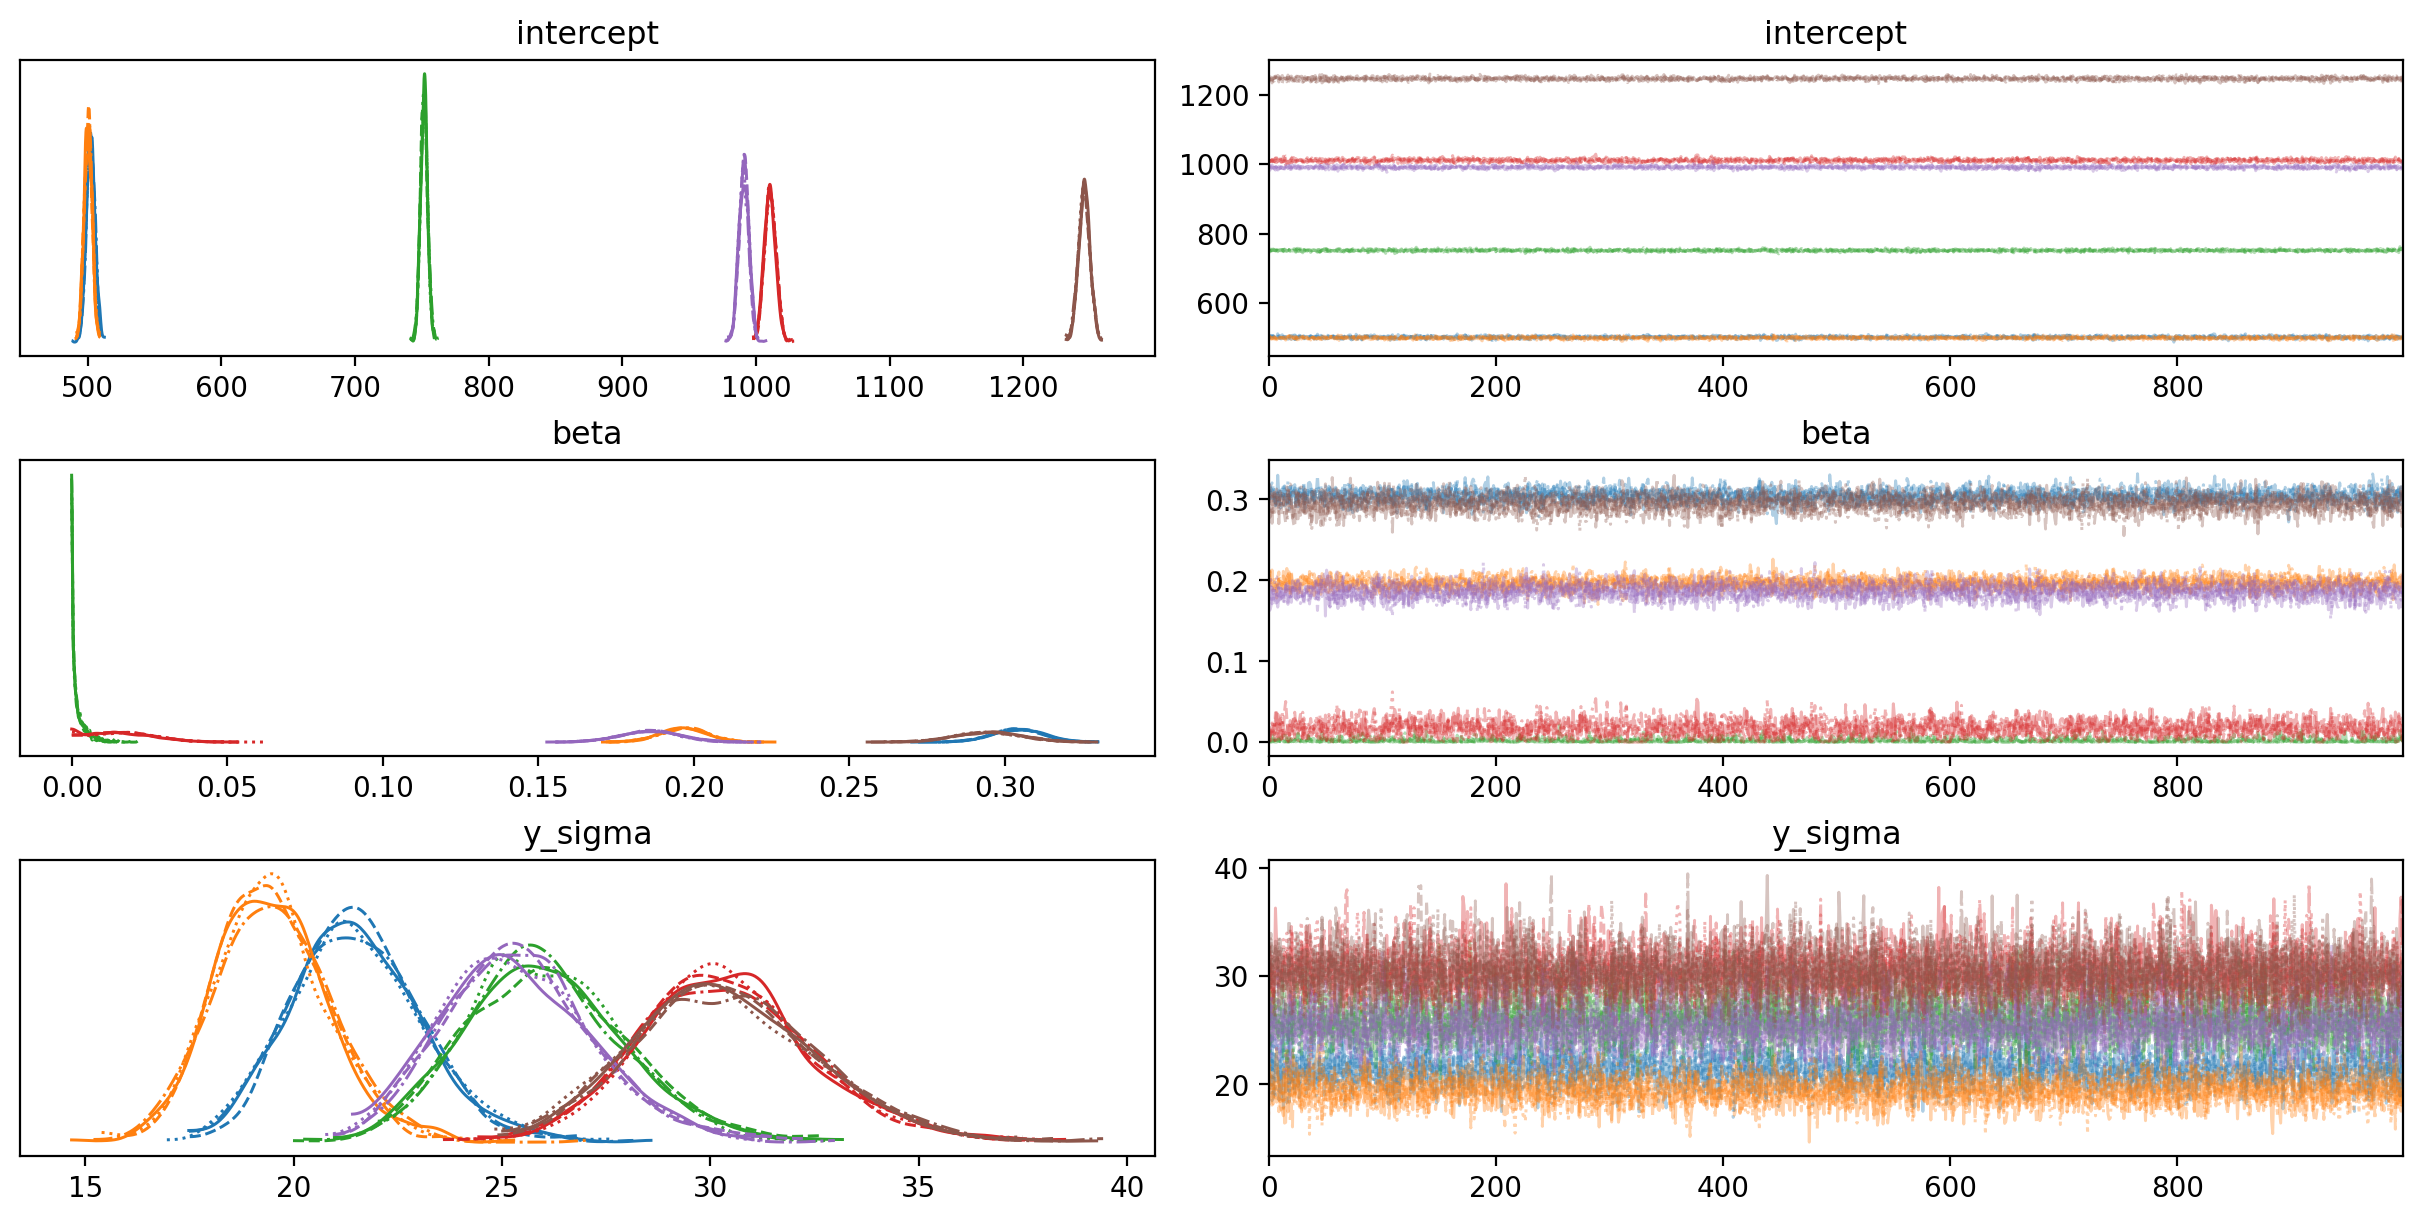

In [30]:
az.plot_trace(model3.idata, var_names="~mu");

Visual plotting of the model fit looks pretty good.

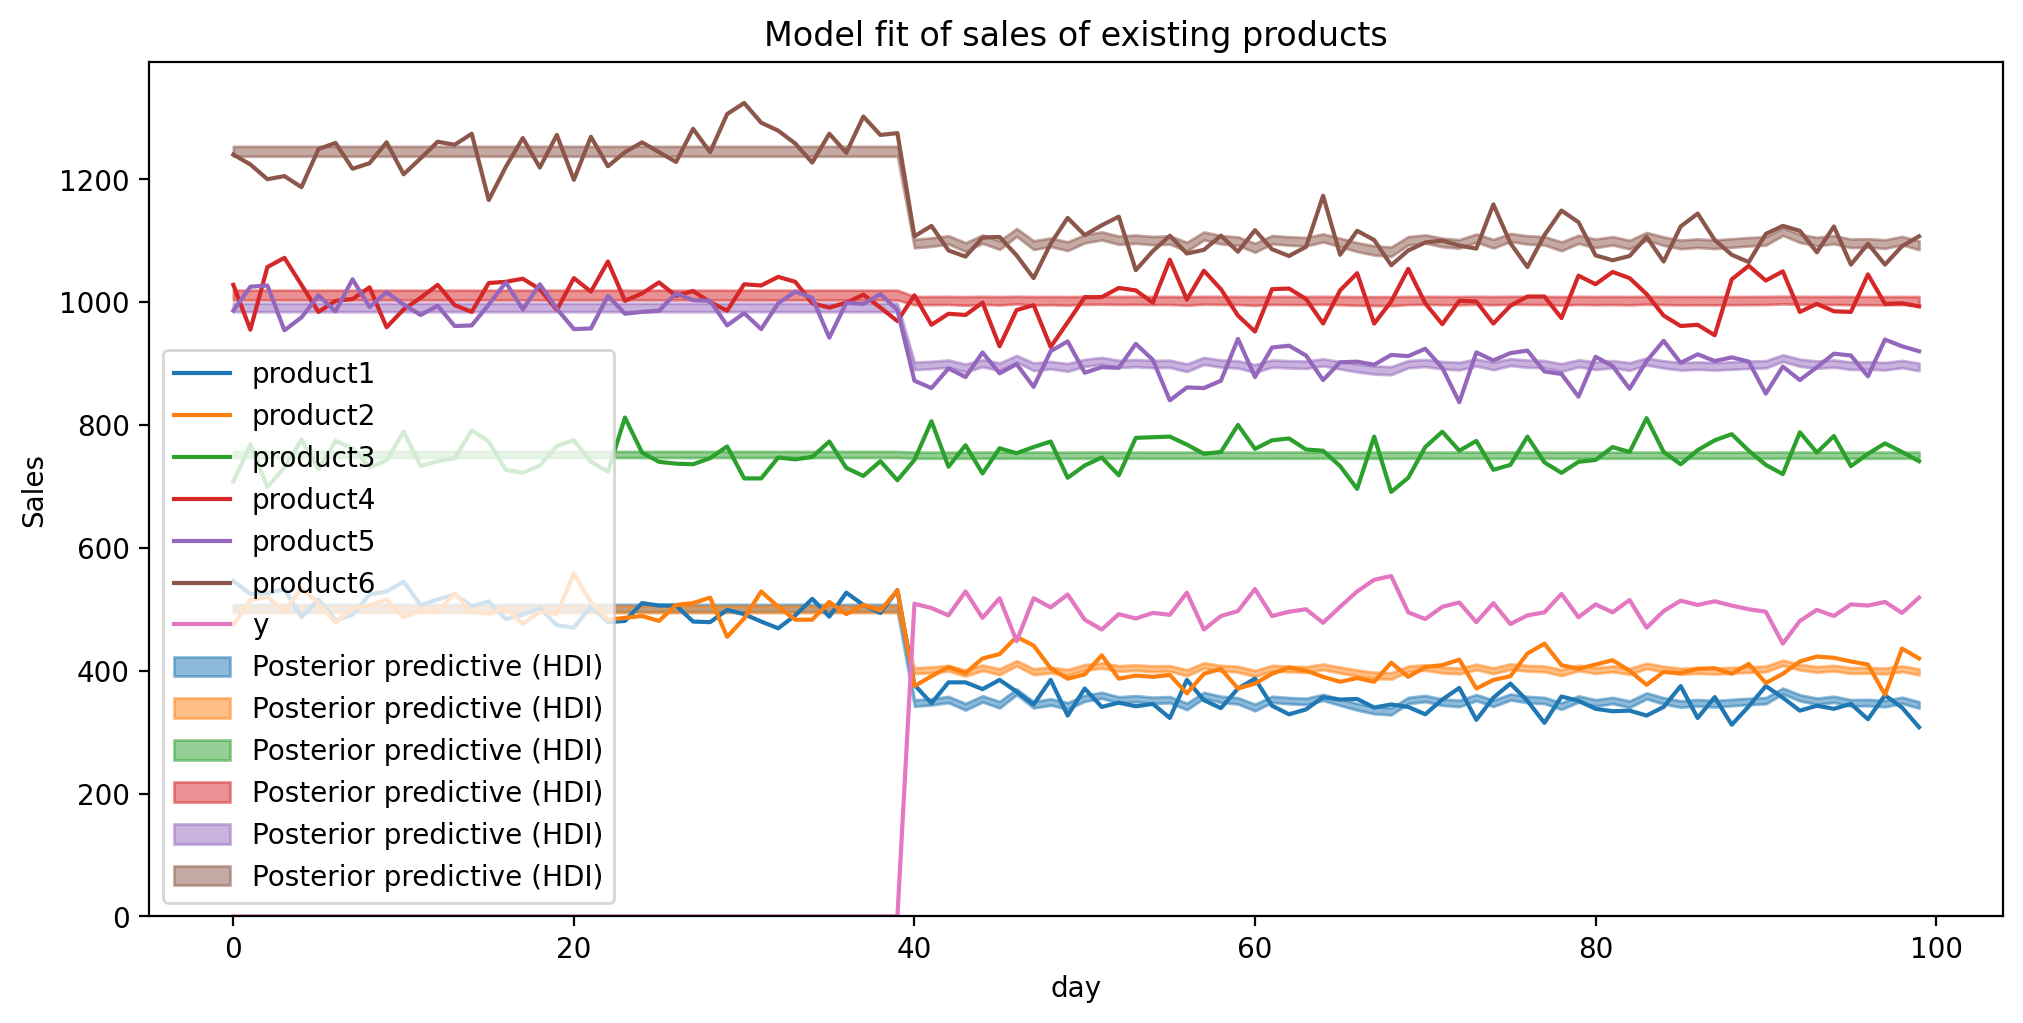

In [31]:
model3.plot_fit(plot_total_sales=False);

As does the plot of the model's estimate of the counterfactual sales.

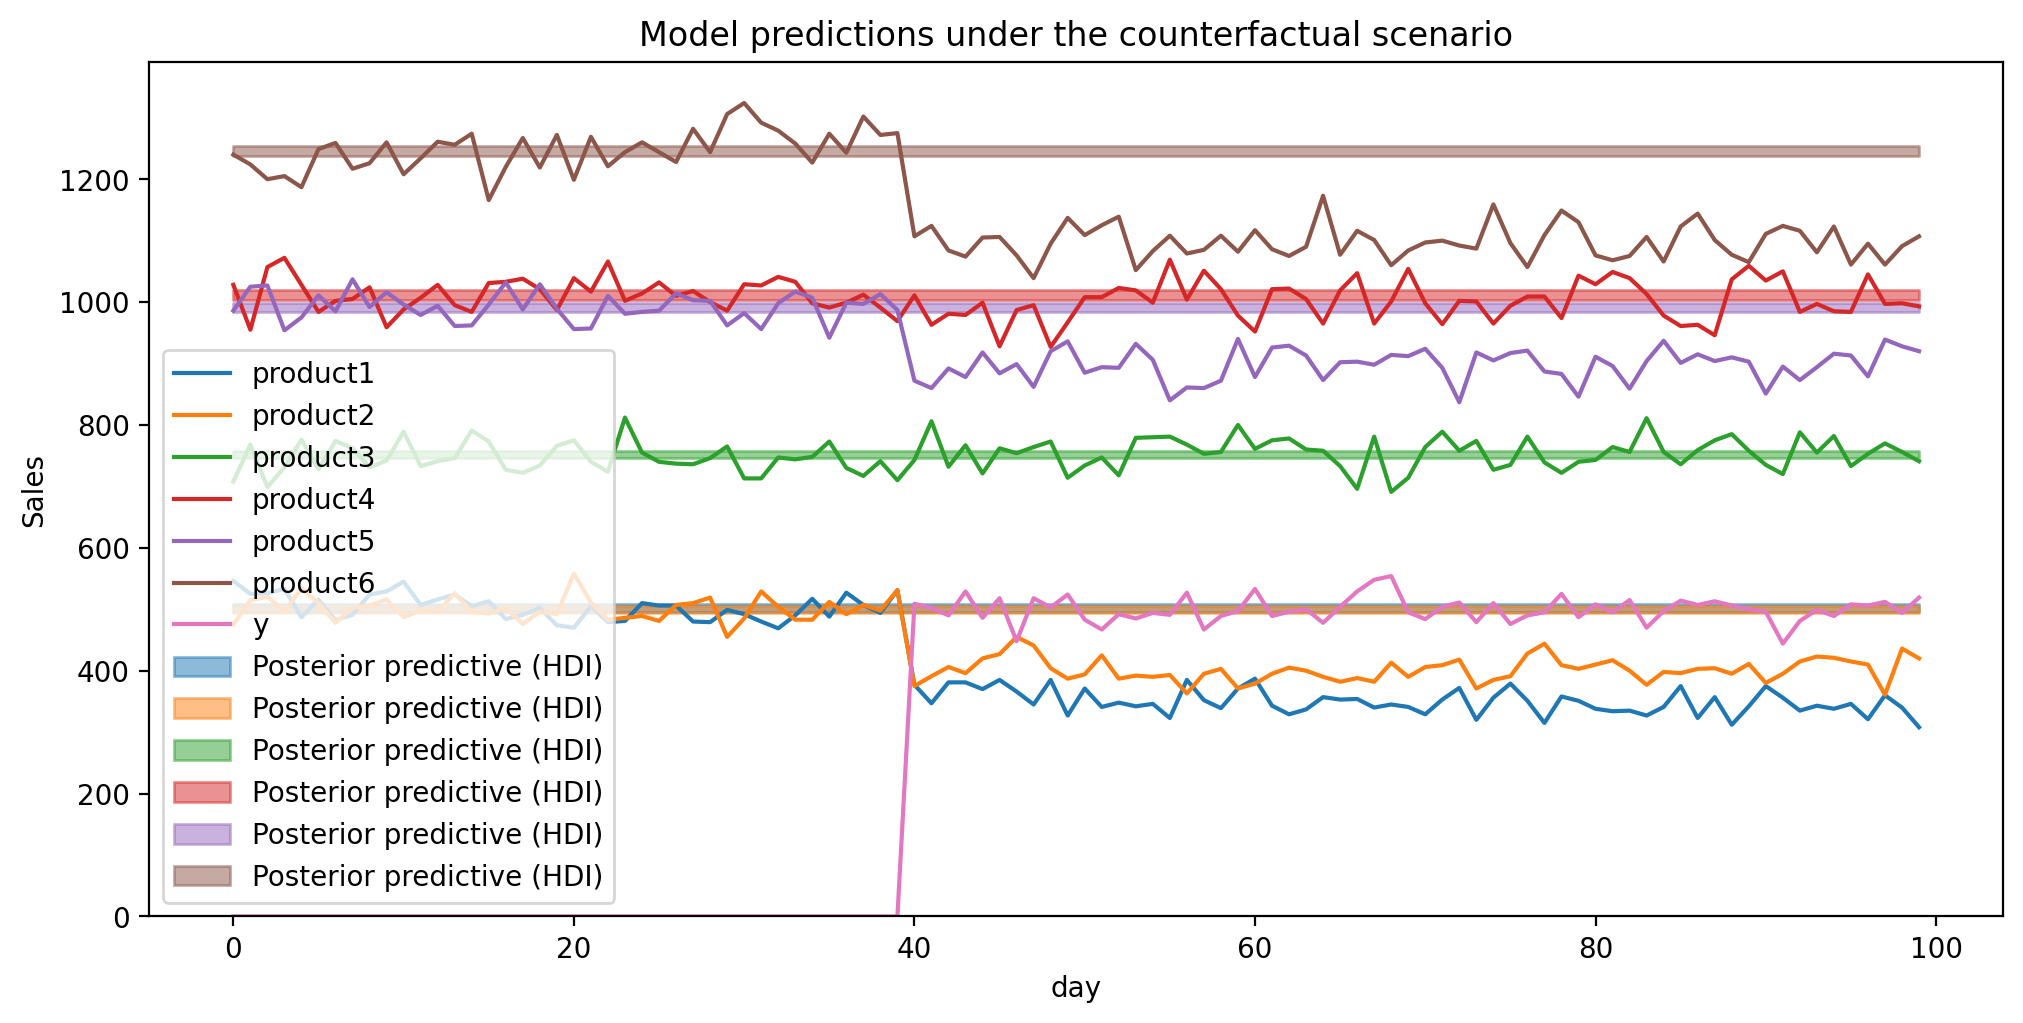

In [32]:
model3.plot_counterfactual(plot_total_sales=False);

And we can visualise the causal impact in terms of sales first, and then in terms of market share.

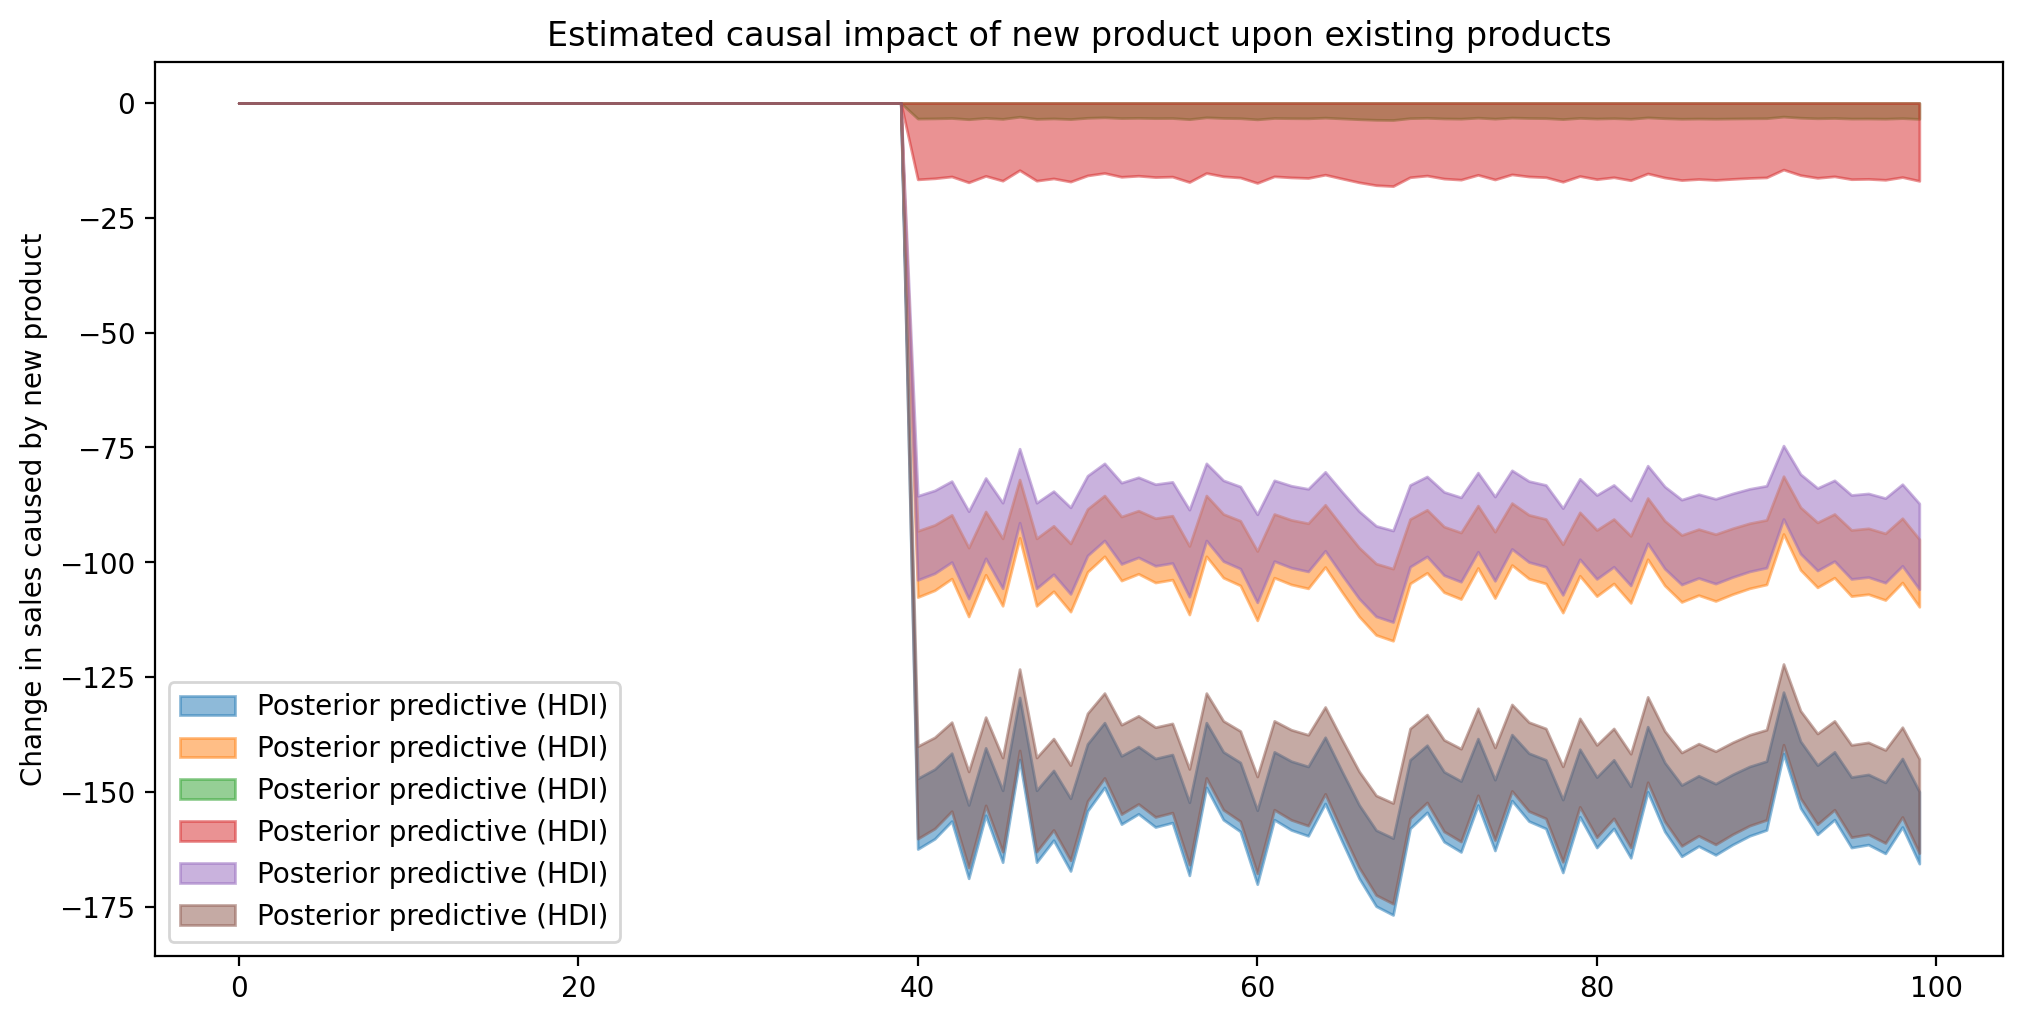

In [33]:
model3.plot_causal_impact_sales();

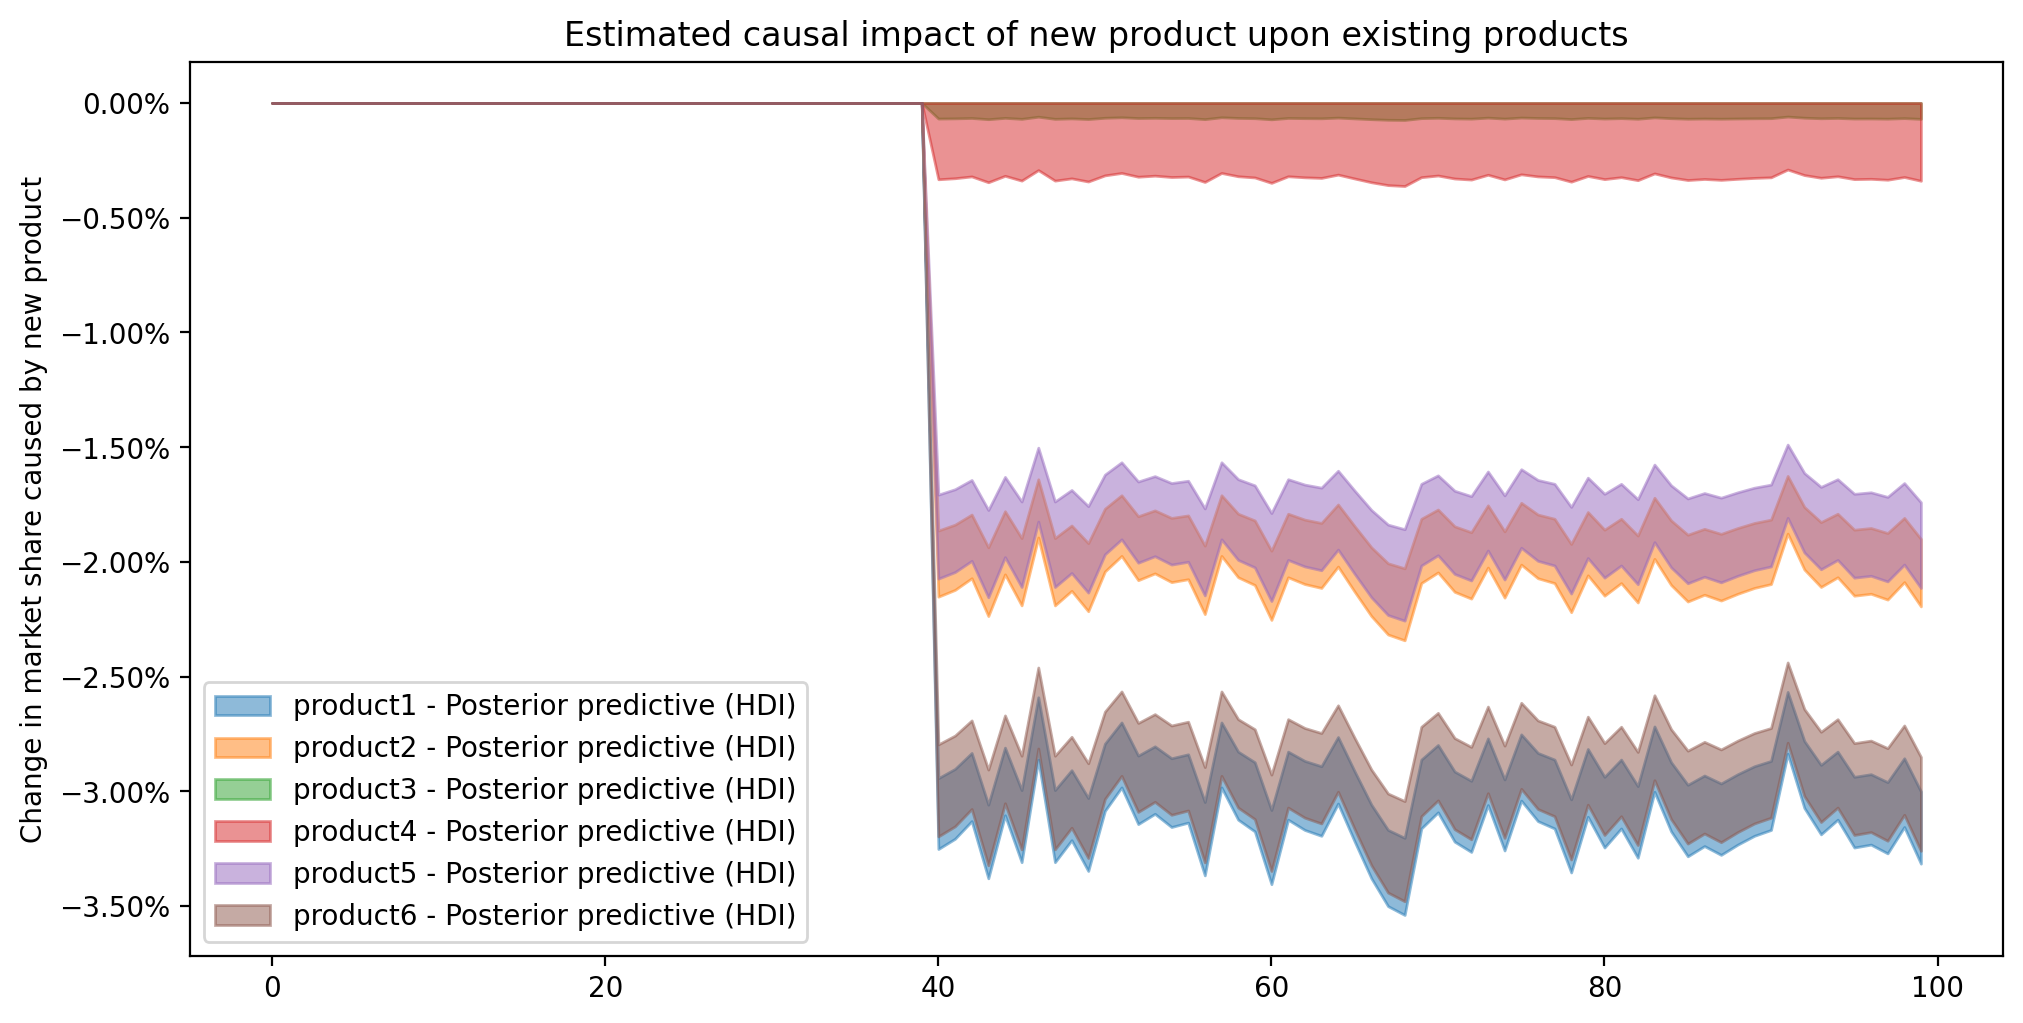

In [34]:
model3.plot_causal_impact_market_share();

Finally, we can inspect the $\beta$ coefficients which tells us what proportion of the new sales come from any given existing product.

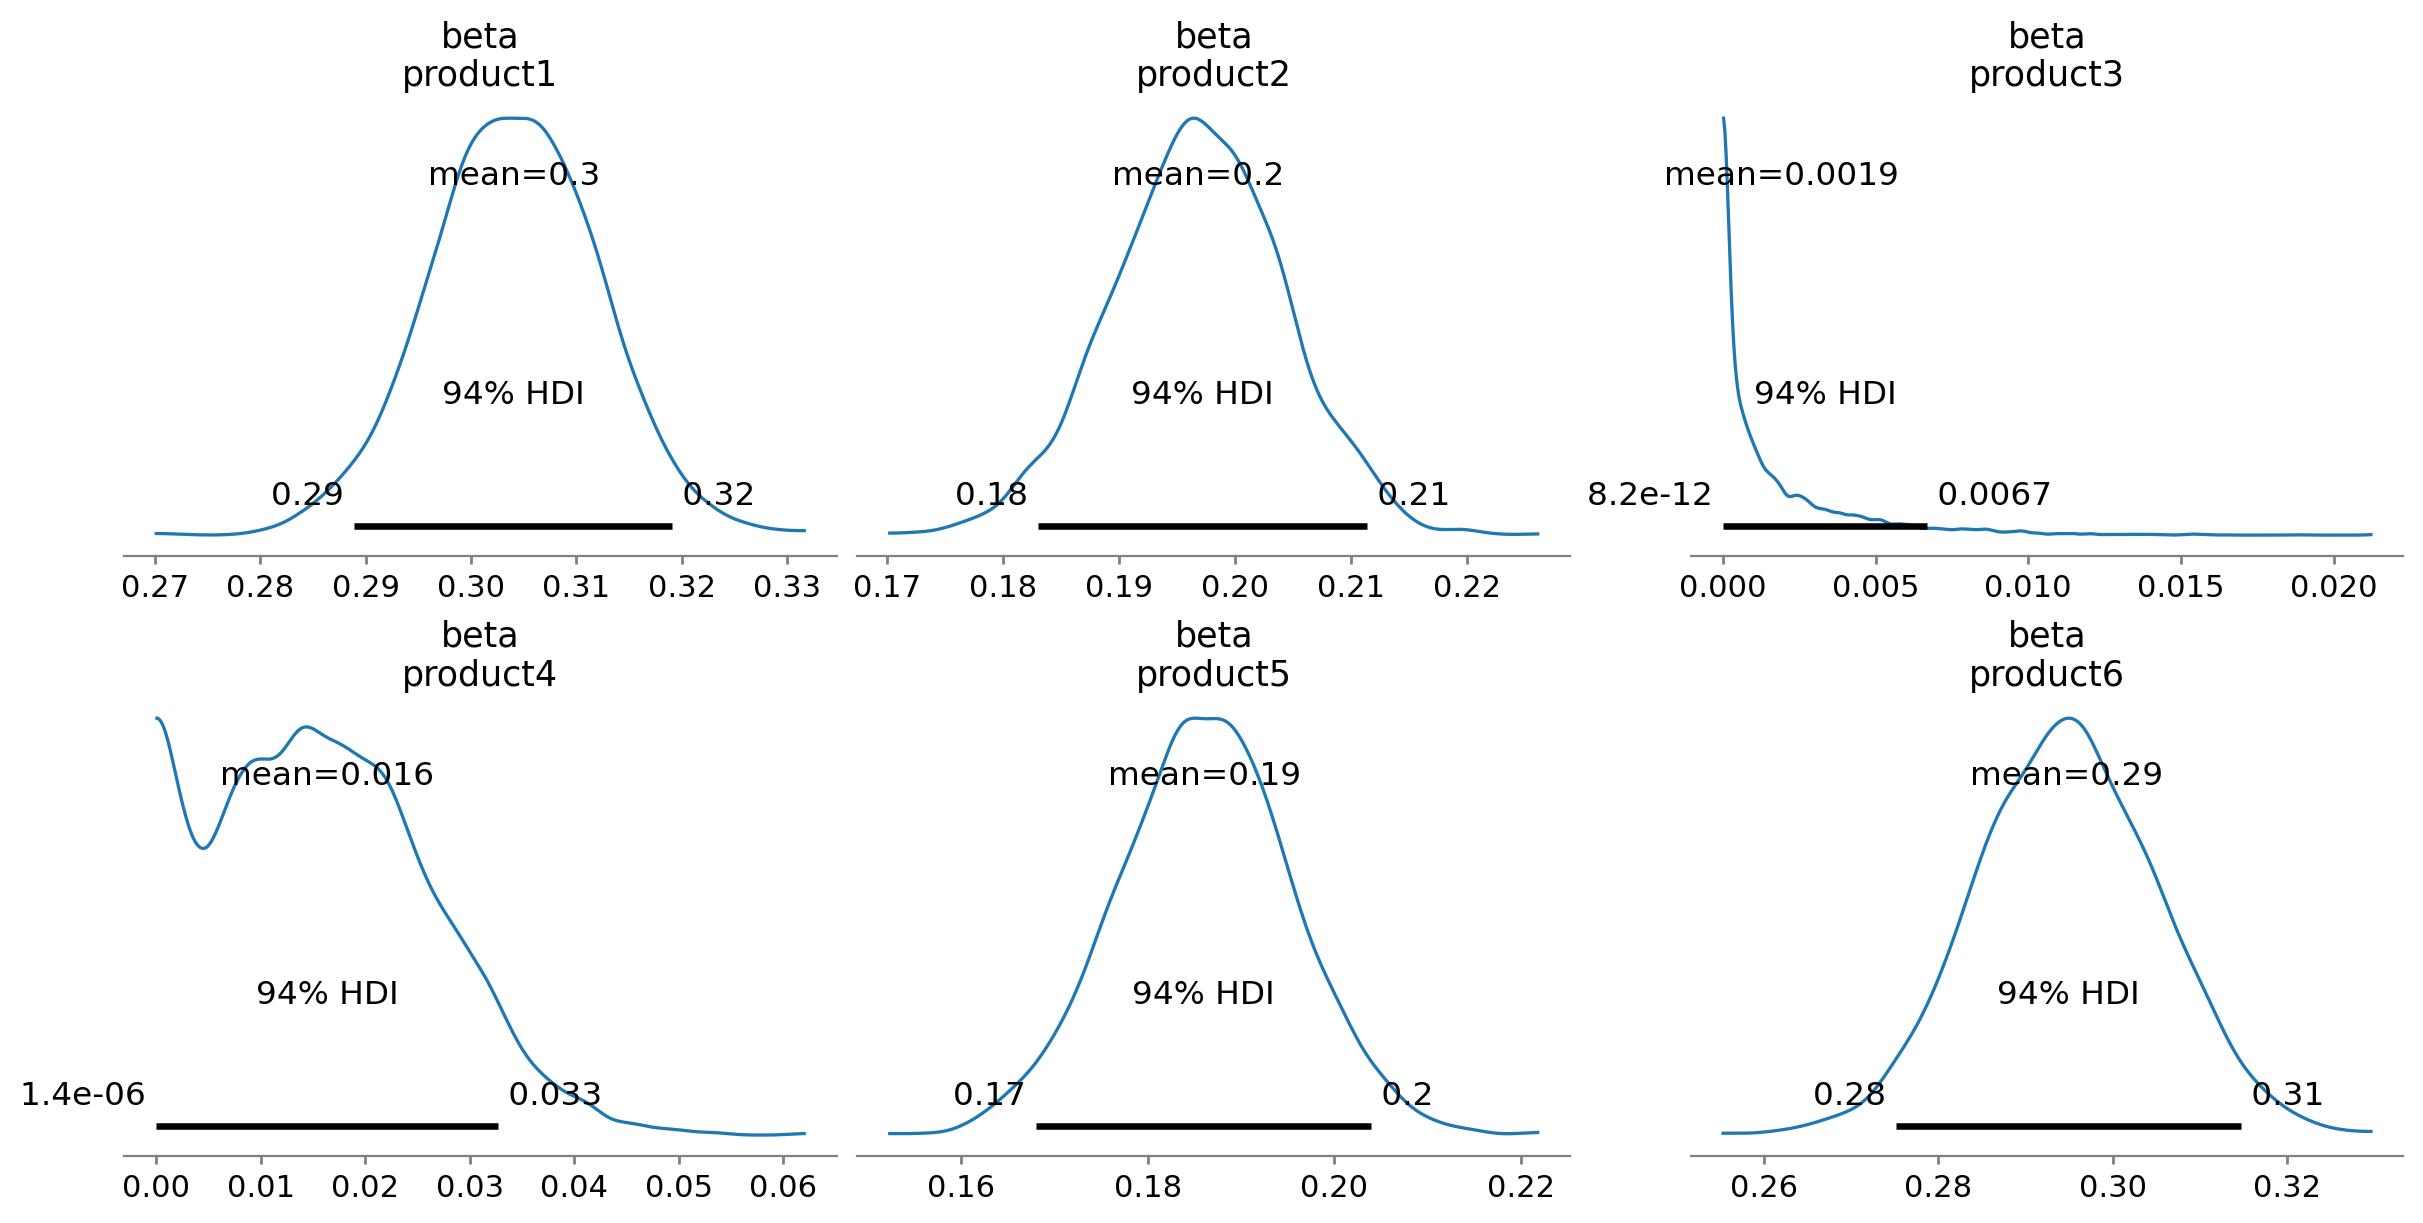

In [35]:
az.plot_posterior(model3.idata, var_names=["beta"], textsize=11, figsize=(12, 6));

So we have seen how it is possible to extend the simplified "our" versus "competitor" analysis to a more detailed analysis of individual products. This is more realistic, but it is still a quite simple scenario. In the real world we would likely have to deal with more complex data, and the MVITS model may not be able to handle these complexities.